In [1]:
import numpy as np, pandas as pd, csv, matplotlib.pyplot as plt, os, re, time
from numpy import exp, pi, sinc, sin, tan, convolve, square, abs, arcsin, arctan, sqrt, cos, shape, array, mean,exp 
from collections import defaultdict 
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from scipy.ndimage import median_filter
from typing import List
from datetime import datetime

from matplotlib.animation import FuncAnimation

import multiprocessing as mp

py_blue = '#1f77b4' 
py_orange = '#ff7f0e' 
py_green = '#2ca02c'
py_red = '#d62728'

# Diffraction modeling

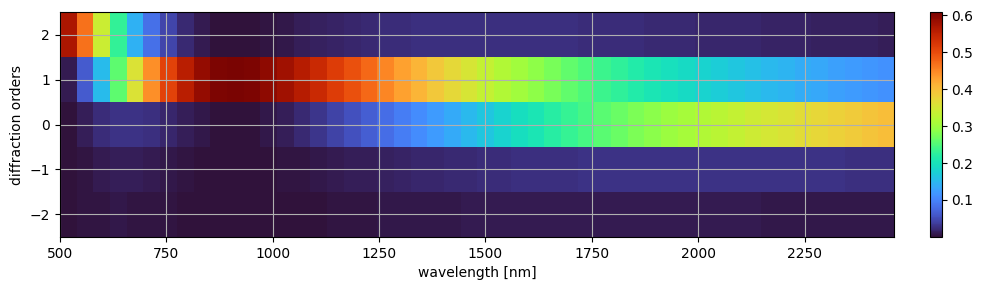

In [2]:
class DiffractionAnalytical:
    
    def __init__(self, wavelengths: List[int], orders: List[int], incident_angles: List[int], period: int, height: float=750, separator: float = 0):
        self.separator = separator
        self.period = period * 1e-9
        self.wavelengths = np.array(wavelengths) * 1e-9 
        self.orders = orders
        self.incident_angles = np.array(incident_angles)/180*np.pi
        self.angles = np.arcsin(sin(self.incident_angles)[:, np.newaxis, np.newaxis] + np.outer(self.orders, self.wavelengths)[np.newaxis, :]/self.period)
        self.frequencies = np.sin(self.angles) / self.wavelengths
        self.height = height * 1e-9
        self.blaze_angle = np.arctan(self.height/self.period)
        self.n = 1.586 + 1.111e4* np.power(np.array(wavelengths, dtype = float), -2) + 4e-5*np.power(np.array(wavelengths, dtype = float), -4)
        
        self.angle_correction = (1 +cos(arcsin(self.orders[:, np.newaxis] * self.wavelengths[np.newaxis, :] / self.period)))/2
        self.model_s_trans, self.model_p_trans = self._calculate_trans_intensities()

    def _calculate_trans_intensities(self):
        ts_coef, tp_coef = self._calcualate_ts_tp_coef()
        offset = (-(self.n[np.newaxis, :]-1)*tan(self.blaze_angle) + sin(self.incident_angles)[: , np.newaxis])/self.wavelengths
        f_transform = sinc((self.frequencies-offset[:, np.newaxis, :])*self.period)
        
        s_intensity = np.square(self.angle_correction) *  square(abs(ts_coef[:, np.newaxis, :] * f_transform))
        p_intensity = np.square(self.angle_correction) *  square(abs(tp_coef[:, np.newaxis, :] * f_transform))
        return s_intensity, p_intensity
    
    def _calcualate_ts_tp_coef(self):
        tilted_incident_angles = self.incident_angles - self.blaze_angle
        trans_angles = arcsin(np.outer(sin(tilted_incident_angles), 1/self.n)) - self.blaze_angle
        ts_coef = 2*cos(tilted_incident_angles)[:, np.newaxis]  / (np.outer(cos(tilted_incident_angles), self.n) + cos(trans_angles))
        tp_coef = 2*cos(tilted_incident_angles)[:, np.newaxis]  / (cos(trans_angles) + self.n + cos(tilted_incident_angles)[:, np.newaxis])
        return ts_coef, tp_coef
    

def compare(incident_angle: int, mode: str = 'trans', polarisation: str = 'S'):
        """ Displays the measured diffraction efficiencies alongside the modeled ones in two separate heatmaps for the angles of incidence and modes provided. """
        if mode not in ['trans', 'reflx']: raise ValueError("Mode must be 'trans' or 'reflx'.")
        #model = DiffractionAnalytical(range(500,2500,10), np.arange(-120, 120), range(-20,20,10), 300_000, height = 750_00)
        model = DiffractionAnalytical(np.arange(500,2500,40), np.arange(-2,3), [0], 6_000, height = 1500)
        index = np.where(np.array([0]) == incident_angle)[0]
        model_intensity = np.squeeze(model.model_s_trans[index])
        plt.figure(figsize = (10,3))
        im = plt.imshow(model_intensity, extent = [min(model.wavelengths*1e9),max(model.wavelengths*1e9),  min(model.orders)-0.5, max(model.orders) + 0.5], cmap='turbo', aspect = 'auto')#, vmin=0, vmax=1)
        plt.grid()
        plt.xlabel('wavelength [nm]')
        plt.ylabel('diffraction orders')
        plt.colorbar(im,orientation='vertical', fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.savefig('heatmap_analytical.png')
        
compare(0)

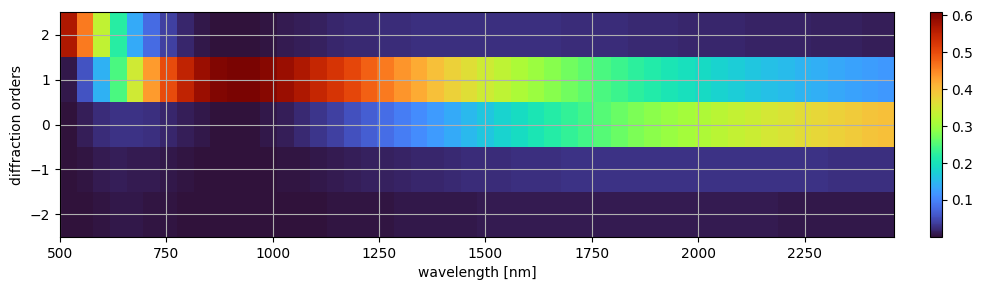

In [3]:
class DiffractionNumerical:
    """output shape (incident_angles, orders, wavelengths)"""
    
    def __init__(self, wavelengths: List[int], orders: List[int], period: int, height: float=750, power_a = 2.4, power_b = 10, fill_factor = 1):
        self.N = 4096  # Number of sample points
        self.unit = 1e-6  # Units in microns
        self.period = period *1e-9  # Width of the rectangular function in microns
        self.x = np.linspace(0, 200 * self.unit, self.N, endpoint=False)  # Space vector in microns
        self.a = np.clip(power_a, 1e-4, 1e4)
        self.b = np.clip(power_b, 1e-4, 1e4)
        self.wavelengths = np.array(wavelengths) * 1e-9  # Convert to meters
        self.orders = np.array(orders)
        self.fill_factor = fill_factor
        self.frequencies = self.orders[np.newaxis, :] / self.period
        self.height = height * 1e-9 
        self.blaze_angle = np.arctan(self.height/self.period)
        self.n = 1.586 + 1.111e4* np.power(np.array(wavelengths, dtype = float), -2) + 4e-5*np.power(np.array(wavelengths, dtype = float), -4)
        self.angle_correction = (1 +cos(arcsin(self.orders[:, np.newaxis] * self.wavelengths[np.newaxis, :] / self.period)))/2
        self.model_s_trans, self.model_p_trans = self._calculate_trans_intensities()

    def _calculate_trans_intensities(self):
        big_ts, big_tp = np.square(np.abs(self._calcualate_ts_tp_coef()))
        reduced_width = self.fill_factor*self.period
        a, b = self.a, self.b
        x_private = self.x[:, np.newaxis]/reduced_width
        y = x_private**a - x_private**b
        curve_maxima = (b/a)**(a/(a-b + 1e-6)) -(b/a)**(b/(a-b + 1e-6))
        if curve_maxima == 0: curve_maxima=1e-8
        blaze_profile = (1- y/curve_maxima) * self.height
        rect = np.where(self.x <= reduced_width, 1, 0)
        rect_shifted = rect[:, np.newaxis]*np.exp(-1j*2*pi*((self.n-1)*blaze_profile/self.wavelengths[np.newaxis, :]))
        
        yf_shifted_all = np.fft.fftshift(np.fft.fft(rect_shifted, axis=0), axes=0)
        xf = np.fft.fftshift(np.fft.fftfreq(self.N, self.x[1] - self.x[0]))
        desired_frequencies = self.orders / self.period
        indices = np.abs(xf[:, np.newaxis] - desired_frequencies).argmin(axis=0)
        s_intensity = np.square(self.angle_correction) * big_ts * np.square(np.abs(yf_shifted_all[indices]))/np.max(np.square(np.abs(yf_shifted_all[indices])))
        p_intensity = np.square(self.angle_correction) * big_tp * np.square(np.abs( yf_shifted_all[indices]))/np.max(np.square(np.abs(yf_shifted_all[indices])))
        return s_intensity, p_intensity
    
    def _calcualate_ts_tp_coef(self):
        tilted_incident_angles =  - self.blaze_angle
        trans_angles = arcsin(np.outer(sin(tilted_incident_angles), 1/self.n)) - self.blaze_angle
        ts_coef = 2*cos(tilted_incident_angles)  / (np.outer(cos(tilted_incident_angles), self.n) + cos(trans_angles))
        tp_coef = 2*cos(tilted_incident_angles) / (cos(trans_angles) + self.n + cos(tilted_incident_angles))
        return ts_coef, tp_coef

def compare(polarisation: str = 'S'):
        model = DiffractionNumerical(range(500,2500,40), range(-2,3), 6_000, height = 1500, power_a = 0, power_b =1)
        model_intensity = np.squeeze(model.model_s_trans)
        plt.figure(figsize = (10,3))
        im = plt.imshow(model_intensity, extent = [min(model.wavelengths*1e9),max(model.wavelengths*1e9),  min(model.orders)-0.5, max(model.orders) + 0.5], cmap='turbo', aspect = 'auto')#, vmin=0, vmax=1)
        plt.grid()
        plt.xlabel('wavelength [nm]')
        plt.ylabel('diffraction orders')
        plt.colorbar(im,orientation='vertical', fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.savefig('heatmap_numerical.png')
        
compare(0)

# Envelope object

In [4]:
class Envelope:
    def __init__(self, data, incident_angles, orders, wavelengths, measured_s_trans, measured_p_trans, measured_s_reflx, measured_p_reflx):
        self.data = data
        self.incident_angles = incident_angles
        print('Incident angles: ')
        print(incident_angles)
        self.orders = orders
        print('Orders:')
        print(orders)
        self.wavelengths = wavelengths
        self.measured_s_trans = measured_s_trans
        self.measured_p_trans = measured_p_trans
        self.measured_s_reflx = measured_s_reflx
        self.measured_p_reflx = measured_p_reflx
        
    def show_peaks(self, orders: list=None, incident_angles: list=None, mode: str='trans', polarisation: str='S'):
        orders = orders or self.orders
        incident_angles = incident_angles or self.incident_angles
        mode = mode or 'trans'
        title = 'Transmittance' if mode == 'trans' else 'Reflectance'
        for i in incident_angles:
            fig, axes = plt.subplots(nrows=len(orders), ncols=1, figsize=(20, 20))
            for m, ax in zip(orders, axes):
                df = self.data[(self.data['mode'] == mode) & (self.data['polarisation'] ==  polarisation) & (self.data['order'] ==  m) & (self.data['incident_angle'] ==  i)]
                for index, row in df.iterrows():
                    ax.plot(row['wavelengths'], row['intensity'], label = str(m), linewidth = 4)
                ax.set_title( title + ' order: ' + str(m) + ',     angle of incidence:   ' +str(i), fontsize = 15)
                ax.set_ylabel(title + ' efficiency', fontsize = 15)
                ax.tick_params(axis="x", labelsize=15)
                ax.tick_params(axis="y", labelsize=15)
                ax.set_xlim(min(self.wavelengths), max(self.wavelengths))
            plt.xlabel('Wavelengths [nm]', fontsize = 15)
            plt.tight_layout()
            
    def show_envelopes(self, orders: list=None, incident_angles: list=None, show_trans = True, show_reflx = False, show_s = True, show_p = False ):
            if orders is None or len(orders) == 0:
                orders = self.orders
            title = 'Transmittance'
            fig, axes = plt.subplots(nrows=len(orders), ncols=1, figsize=(20, 20))
            for m, ax in zip(orders, axes):
                m_index = np.where(self.orders ==m)[0][0]
                for incident_angle in incident_angles:
                    index = np.where(np.array(self.incident_angles) == incident_angle)[0][0]
                    if show_trans and show_s:
                        efficiencies = np.squeeze(self.measured_s_trans[index][m_index])*100
                        ax.plot(self.wavelengths, efficiencies, linewidth = 4, label = 'S transmission, incident angle = ' + str(self.incident_angles[index]) + '°')
                    if show_trans and show_p: 
                        efficiencies = np.squeeze(self.measured_p_trans[index][m_index])*100
                        ax.plot(self.wavelengths, efficiencies, linewidth = 4, label = 'P transmission, incident angle = ' + str(self.incident_angles[index]) + '°')
                    if show_reflx and show_s: 
                        efficiencies = np.squeeze(self.measured_s_reflx[index][m_index])*100
                        ax.plot(self.wavelengths, efficiencies, linewidth = 4, label = 'S reflection, incident angle = ' + str(self.incident_angles[index]) + '°')
                    if show_reflx and show_p: 
                        efficiencies = np.squeeze(self.measured_p_reflx[index][m_index])*100
                        ax.plot(self.wavelengths, efficiencies, linewidth = 4, label = 'P reflection, incident angle = ' + str(self.incident_angles[index]) + '°')
                ax.set_title('Diffracction order: ' + str(m), fontsize = 16)
                ax.set_ylabel('Diff. efficiency [%]', fontsize = 16)
                ax.tick_params(axis="x", labelsize=16)
                ax.tick_params(axis="y", labelsize=16)
                ax.set_xlim(min(self.wavelengths), max(self.wavelengths))
                ax.legend(fontsize = 16)
            plt.xlabel('Wavelengths [nm]', size =16)
            plt.tight_layout()
            plt.savefig('individual.png')

    def show_envelopes_heatmap(self, incident_angle: int, mode: str = 'trans', polarisation: str = 'S'):
        if mode not in ['trans', 'reflx']: raise ValueError("Mode must be 'trans' or 'reflx'.")
        model_intensity, measured_intensity = self._get_intensities(mode, incident_angle, polarisation)
        
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
        for intensity, ax, title in zip([model_intensity, measured_intensity], axes, ['Model', 'Measurement']):
            im = ax.imshow(intensity, cmap='turbo', extent = [min(self.wavelengths),max(self.wavelengths),  min(self.orders)-0.5, max(self.orders) + 0.5], aspect = 'auto')#, vmin=0, vmax=1)
            ax.set_title(title+' '+ str(incident_angle) +' incident angle in '+ mode, size=22)
            ax.set_xlabel('wavelength [nm]', size = 15)
            ax.set_ylabel('efficiency of mth order', size = 15)
            ax.grid()
            fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        plt.tight_layout()
        
    def _get_intensities(self, mode, incident_angle, polarisation):
        index = np.where(np.array(self.incident_angles) == incident_angle)[0]
        if index.size == 0: raise ValueError(f"No incident angle matches {incident_angle}.")
        if mode == 'reflx':
            if polarisation == 'S':
                measured_intensity = np.squeeze(self.measured_s_reflx[index])
                model_intensity = np.squeeze(self.model_efficiency.model_s_reflx[index])
            if polarisation == 'P':
                measured_intensity = np.squeeze(self.measured_p_reflx[index])
                model_intensity = np.squeeze(self.model_efficiency.model_p_reflx[index])
        if mode == 'trans': 
            if polarisation == 'S':
                measured_intensity = np.squeeze(self.measured_s_trans[index])
                model_intensity = np.squeeze(self.model_efficiency.model_s_trans[index])
            if polarisation == 'P':
                measured_intensity = np.squeeze(self.measured_p_trans[index])
                model_intensity = np.squeeze(self.model_efficiency.model_p_trans[index])
        return model_intensity, measured_intensity

# FileProcessor utility class

In [5]:
class FileProcessor():
    @staticmethod
    def from_directory(directory_path: str, peak_width):
        """ returns Envelope object from provided directory path of scanned csv"""
        files = sorted([os.path.join(directory_path, file) for file in os.listdir(directory_path) if 'S_'in file or 'P_' in file])
        with mp.Pool(processes = os.cpu_count()) as pool:
            processed_data = pool.map(FileProcessor._load_curves, files)
        envelope = FileProcessor._create_envelope(processed_data, peak_width)
        return envelope

    @staticmethod
    def from_csv(file_path: str, peak_width = 20):
        """ returns Envelope object from provided csv file containing all the recordings"""
        number_of_recordings = 666
        raw_df = pd.read_csv(file_path, dtype = float,skiprows=[1], nrows = number_of_recordings)
        num_columns = raw_df.shape[1] - 3
        processed_data = []
        for i in range(0,num_columns,2):  # We use a step of 4 assuming every dataset spans 4 columns
            pair = FileProcessor._extract_data_pairs(raw_df, i)
            if pair != 0: processed_data.append(pair)
        envelope = FileProcessor._create_envelope(processed_data, peak_width)
        return envelope
    
    @staticmethod
    def _create_envelope(processed_data, peak_width):
        """ creates the envelope object from measurement data processed to lists"""
        data = pd.DataFrame(processed_data, columns = ['polarisation', 'order', 'mode', 'angle', 'incident_angle', 'center', 'slope', 'start_w', 'stop_w', 'wavelengths', 'intensity'])
        incident_angles = sorted(data['incident_angle'].unique())
        orders = sorted(data['order'].unique()) 
        wavelengths  = range(500,2500,peak_width)
        measured_s_trans = FileProcessor._get_measured('S', 'trans', wavelengths, incident_angles, orders, data,peak_width)
        measured_s_trans = median_filter(measured_s_trans, size=(1, 1, 3), mode='reflect')
        measured_s_reflx = FileProcessor._get_measured('S', 'reflx', wavelengths, incident_angles, orders, data,peak_width) 
        measured_s_reflx = median_filter(measured_s_reflx, size=(1, 1, 3), mode='reflect')
        measured_p_trans = FileProcessor._get_measured('P', 'trans', wavelengths, incident_angles, orders, data,peak_width)
        measured_p_trans = median_filter(measured_p_trans, size=(1, 1, 3), mode='reflect')
        measured_p_reflx = FileProcessor._get_measured('P', 'reflx', wavelengths, incident_angles, orders, data,peak_width) 
        measured_p_reflx = median_filter(measured_p_reflx, size=(1, 1, 3), mode='reflect')
        return Envelope(data, incident_angles, orders, wavelengths, measured_s_trans, measured_p_trans, measured_s_reflx, measured_p_reflx)    
    
    @staticmethod
    def _extract_data_pairs(df, start_col):
        """ returns processed data arrays from dataframes of wavelengths-intensity pair from main csv"""
        pair_df = df.iloc[:, [start_col, start_col+1]].dropna()  # Drop NaN values which are non-numeric rows
        pair_df = pair_df.apply(pd.to_numeric, errors='coerce')
        pair_df = pair_df.dropna()
        name = pair_df.columns[0]
        if len(name) > 30: # normal  length except for baselines
            info = name.split('_')
            data_array = FileProcessor._get_data_array(info, pair_df)
            return data_array
        else:
            return 0
        
    @staticmethod
    def _load_curves(file_path: np.ndarray):
        """ returns processed data arrays from dataframes of wavelengths-intensity pair from main directory"""
        pair_df = pd.read_csv(file_path, header = 1)
        column = pair_df.iloc[:, 1]
        sep_index = column[column.isnull()].index[0]
        pair_df = pair_df.iloc[:sep_index]
        pari_df = pari_df.drop(['Unnamed: 2'], axis = 1)
    
        file_name = file.split('/')[-1]
        info = file_name.split('_')
        data_array = FileProcessor._get_data_array(info, pair_df)
        
        return data_array
    
    @staticmethod
    def _get_data_array(info, pair_df):
        wavelengths = np.array(pair_df.iloc[:, 0])
        intensity = np.array(pair_df.iloc[:, 1])
        polarisation, mode, incident_angle, order, dif_angle, curve_range = info[0], info[2], int(info[5]), int(info[7]), float(info[10]), info[12].split('-')
        start_w = int(curve_range[0])
        stop_w = int(curve_range[1])
        if order == 0: 
            start_w = 500
            stop_w = 2500
        center = int((start_w + stop_w)/2)
        angle = dif_angle + incident_angle
        if mode == 'trans': 
            angle = 180 + angle if angle < 0  else 180 - angle

        usable = min(len(intensity), len(wavelengths))
        intensity = intensity[:usable]
        wavelengths = wavelengths[:usable]
        wavelengths = np.array([float(w) for w, i in zip(wavelengths, intensity) if w % 4 == 0])
        intensity = np.array([float(i) for w, i in zip(wavelengths, intensity) if w % 4 == 0])
        slope = cos(dif_angle/180*pi)/order if order != 0 else 1

        return [polarisation, order, mode, dif_angle, incident_angle, center, slope, start_w, stop_w, wavelengths, intensity]
    
    @staticmethod
    def _get_measured(polarisation: str, mode: str, wavelengths: list, incident_angles: list, orders: list, data: pd.DataFrame, peak_width):
        measured = np.full([len(incident_angles), len(orders), len(wavelengths)], np.nan)
        for i in incident_angles:  
            for m in orders:
                curve_df = data[(data['order'] == m) & (data['polarisation'] == polarisation) & (data['mode'] == mode) & (data['incident_angle'] == i)]
                for index, row in curve_df.iterrows():
                    if m == 0:
                        intensity = np.array(row['intensity'])
                        measured[np.where(incident_angles == i)[0][0]][np.where(orders == m)[0][0]][:] = intensity[-2::-int(peak_width/4)]
                    else:
                        index = int((row['start_w'] - min(wavelengths))/peak_width)
                        measured[np.where(incident_angles == i)[0][0]][np.where(orders == m)[0][0]][index] = max(np.array(row['intensity']))
        return measured

## Creating objects representing diffraction measurements from linear and curved gratings

In [6]:
linear_grating = FileProcessor.from_csv('/kaggle/input/measured2/6um_all_envelopes.csv')
curved_grating = FileProcessor.from_csv('/kaggle/input/upper-blaze/real_upper_zero_order.csv', peak_width = 40)

Incident angles: 
[-20, 0]
Orders:
[-3, -2, -1, 0, 1, 2, 3]
Incident angles: 
[0]
Orders:
[-2, -1, 0, 1, 2]


## Comparison of diffraction efficiencies for different angles of incidence

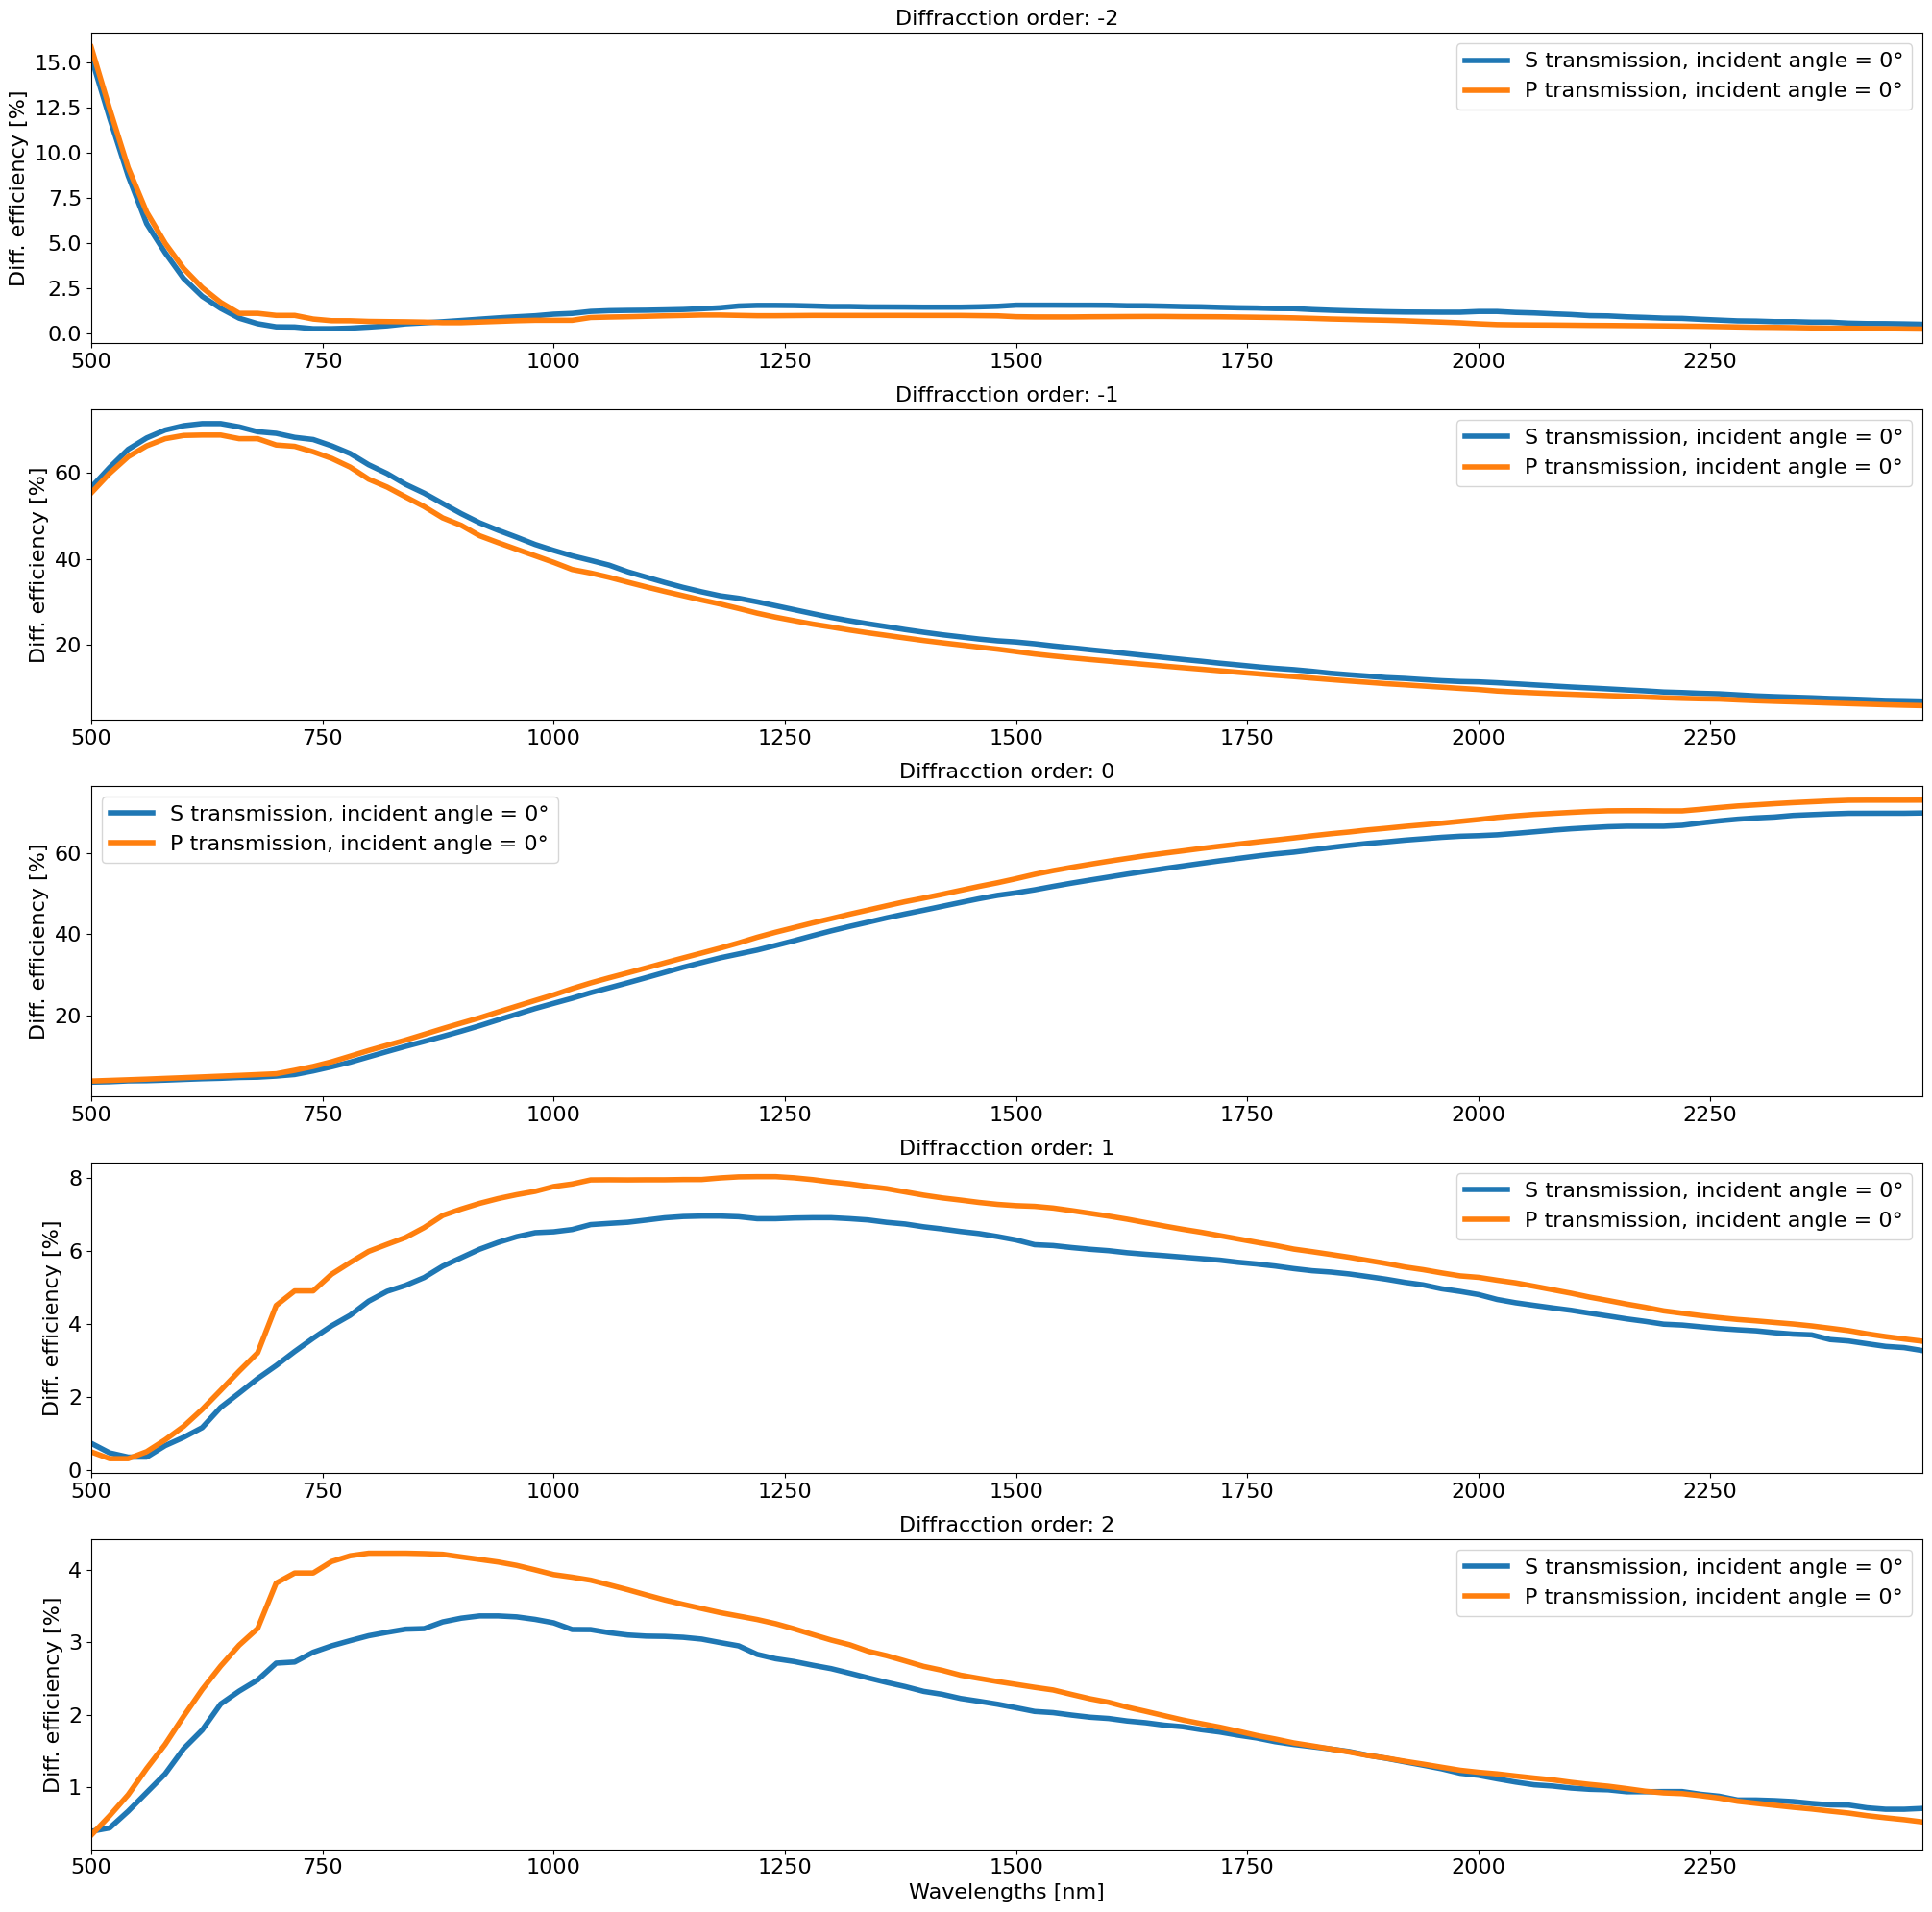

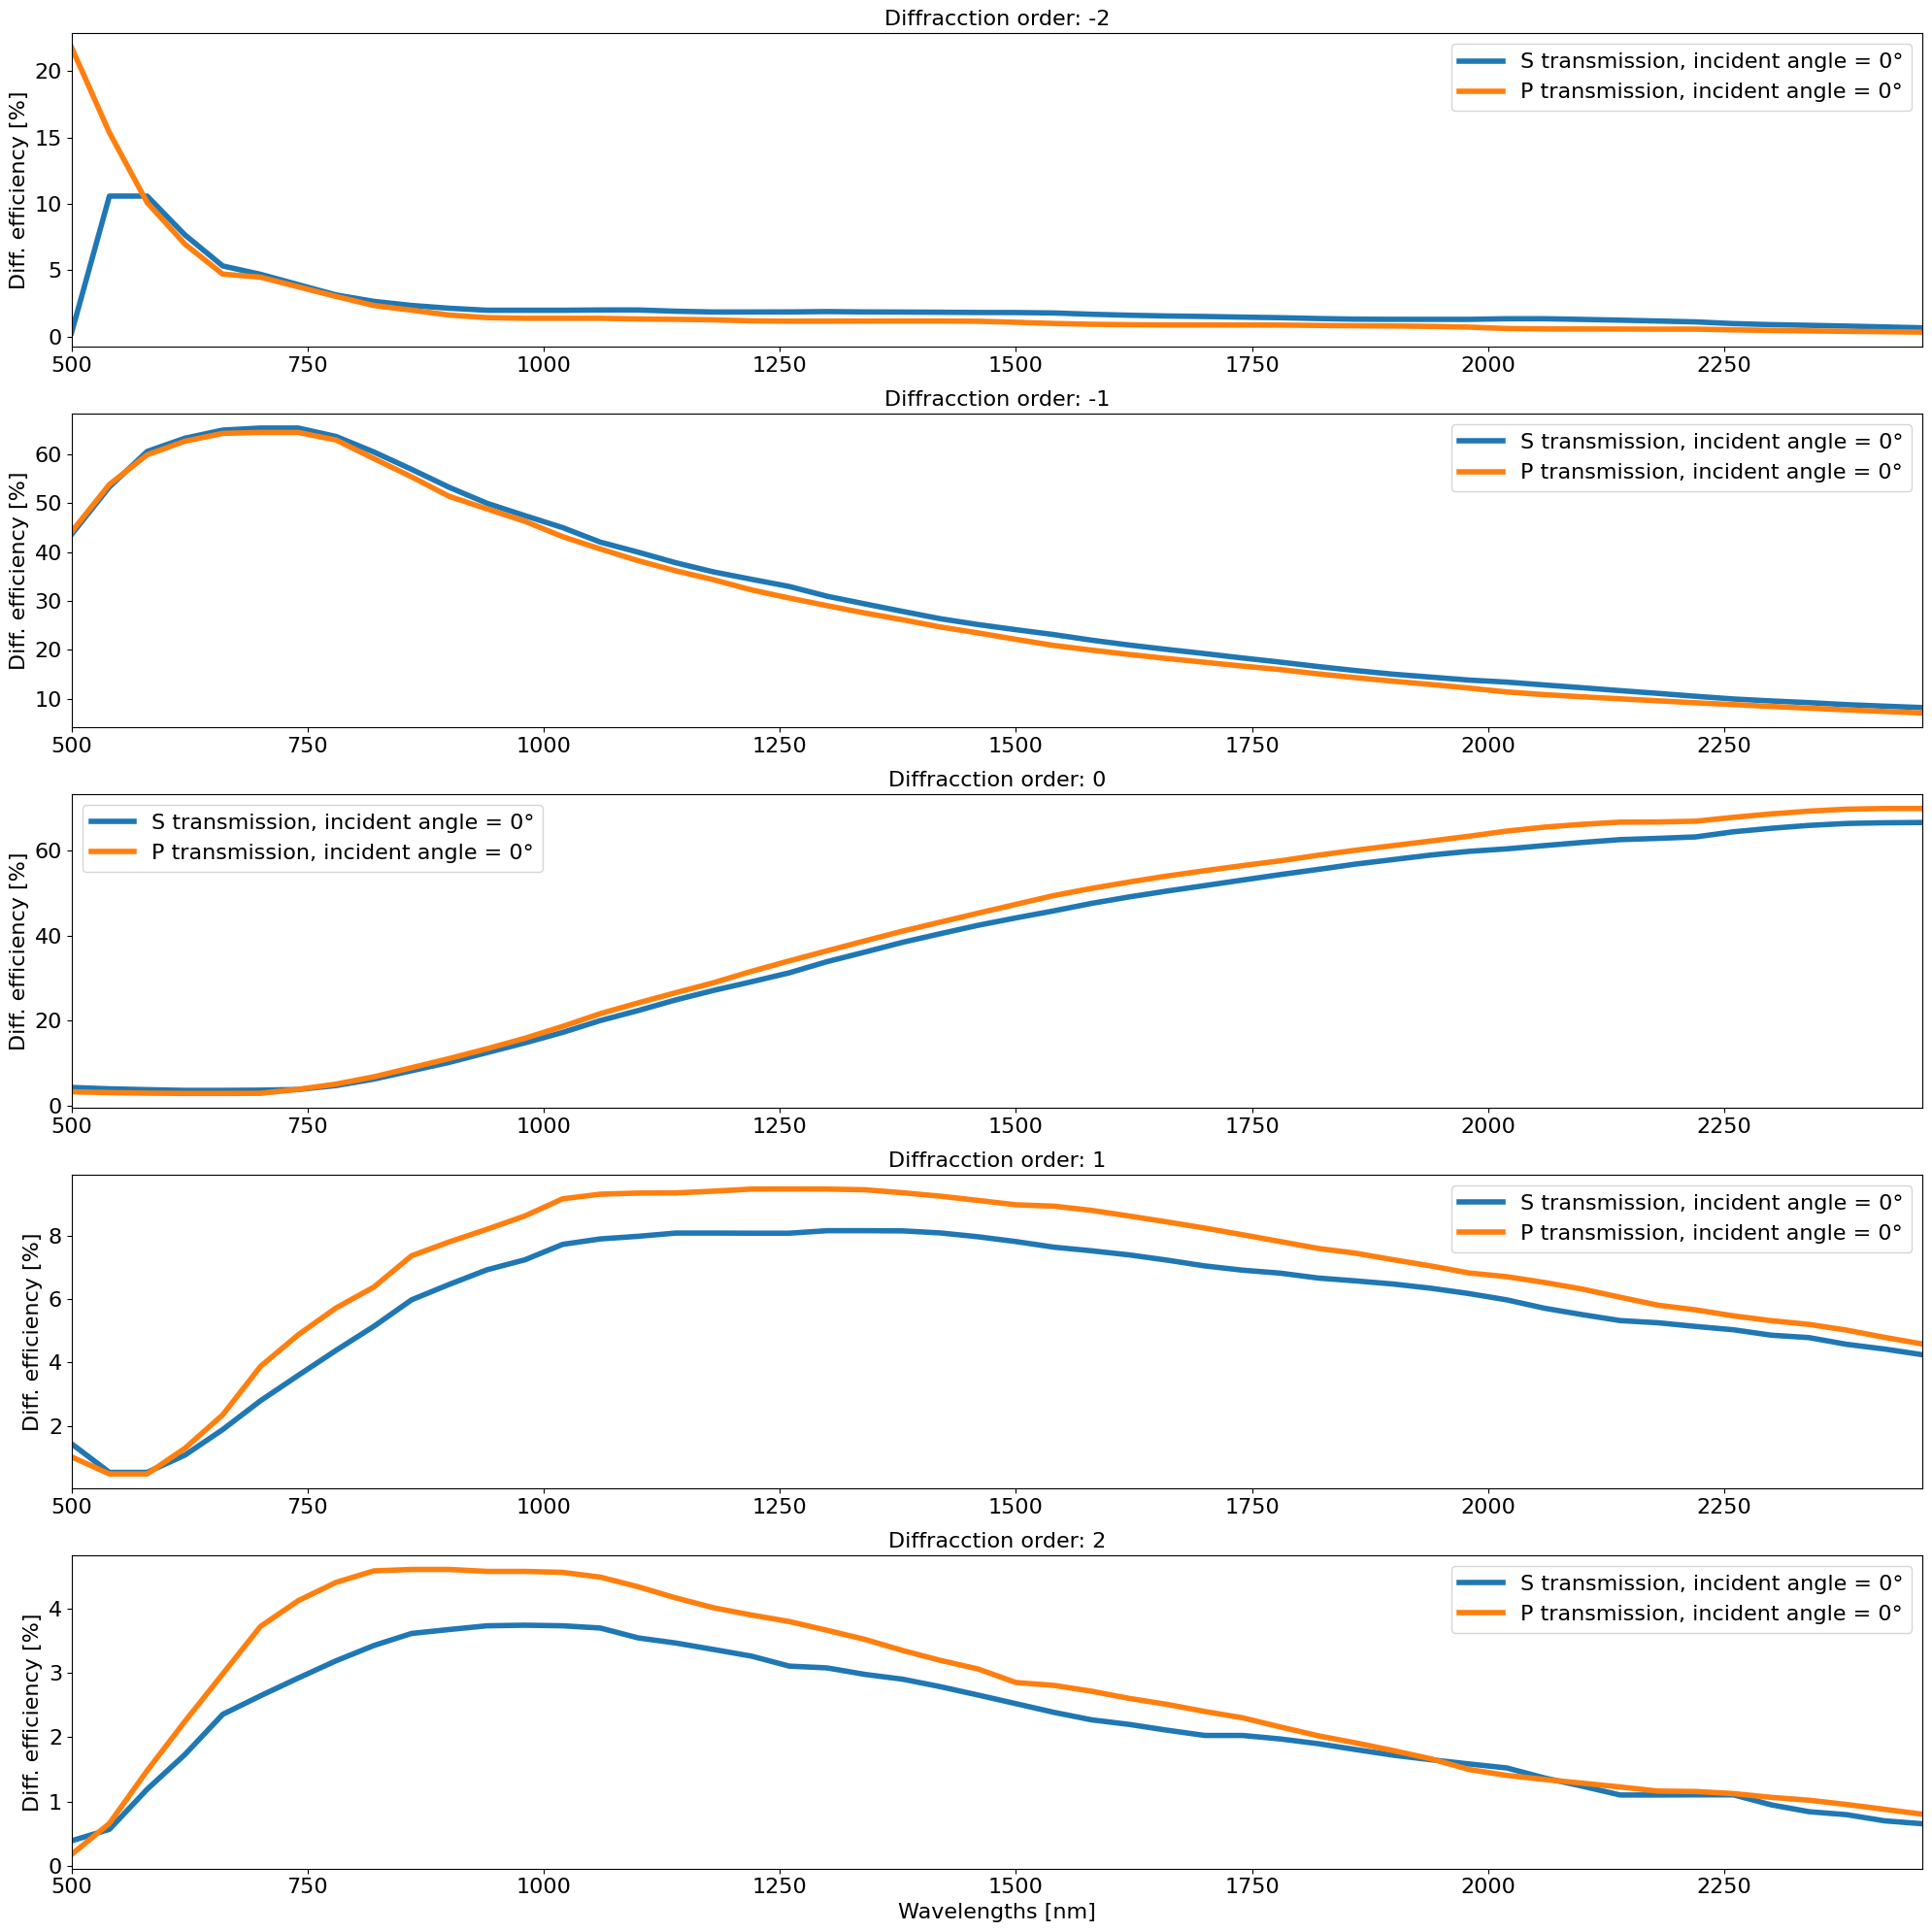

In [7]:
linear_grating.show_envelopes(incident_angles = [0], show_p = True, orders = np.arange(-2,3))
plt.savefig('linear_polarisations.png')
curved_grating.show_envelopes(incident_angles = [0], show_p = True)
plt.savefig('curved_polarisations.png')

## Comparison of reflectance diffraction efficiencies in S and P polarisations

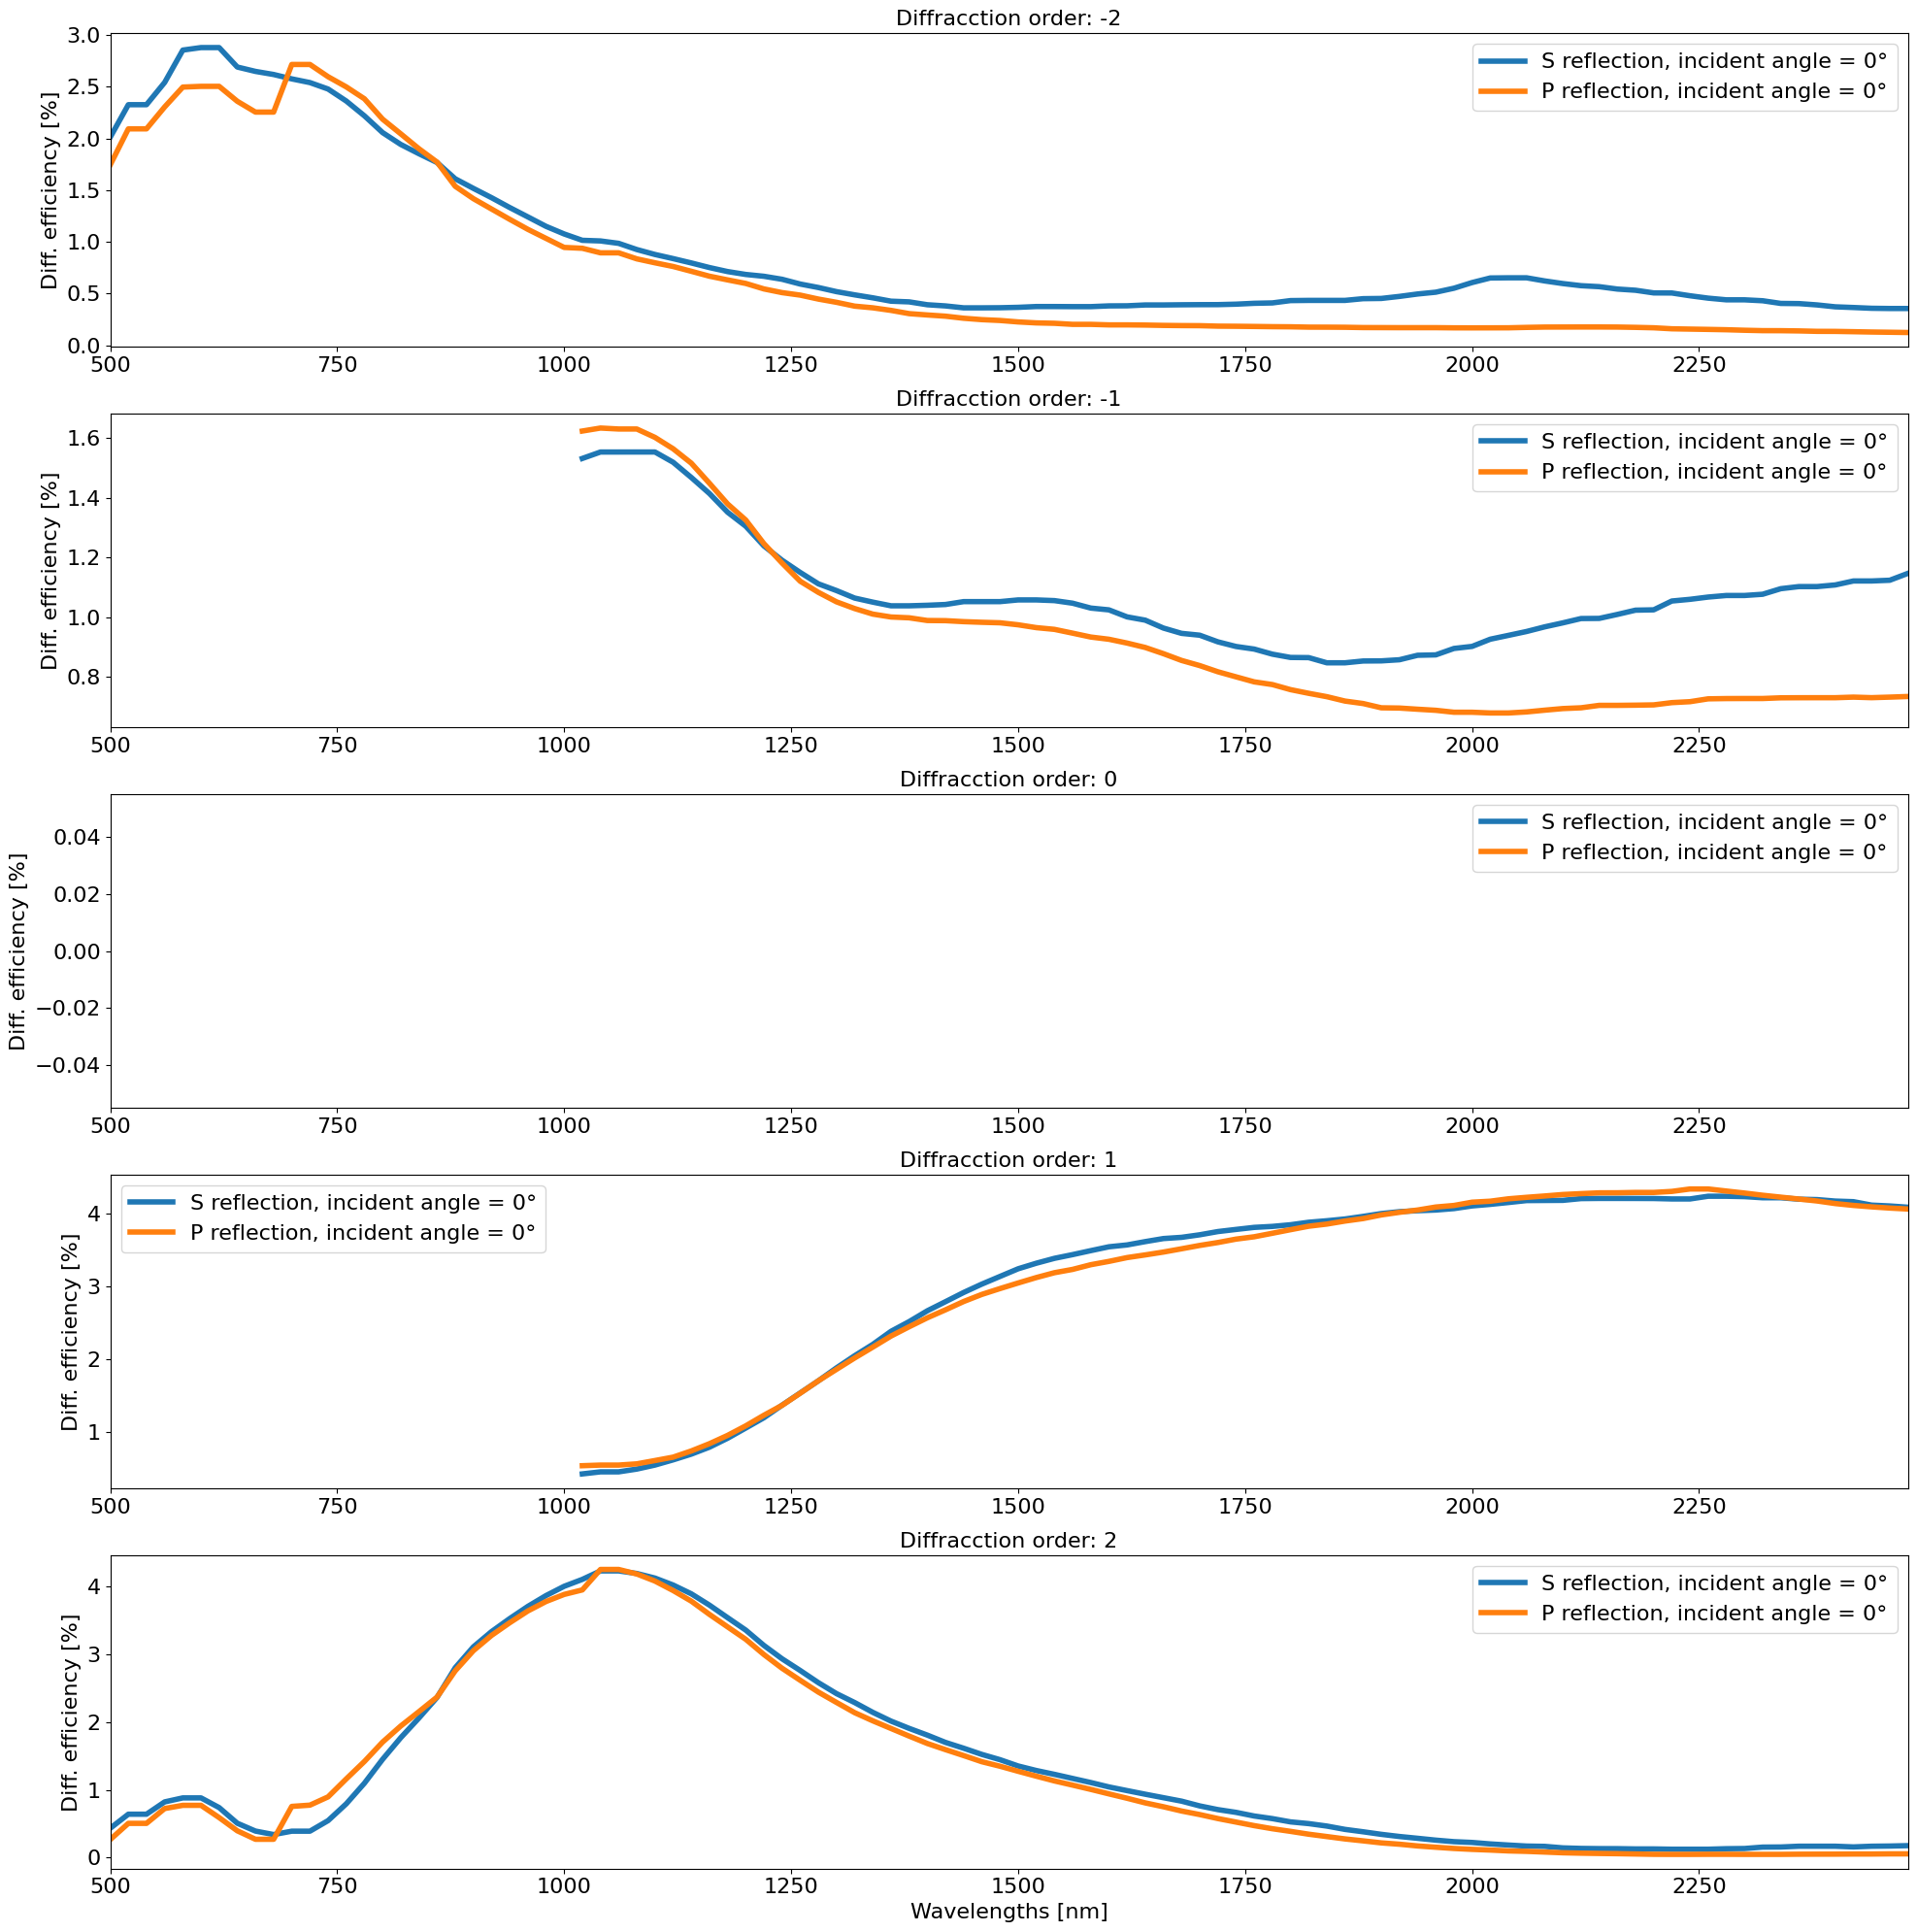

In [8]:
linear_grating.show_envelopes(orders = np.arange(-2,3), incident_angles = [0], show_trans = False, show_reflx = True, show_p = True)

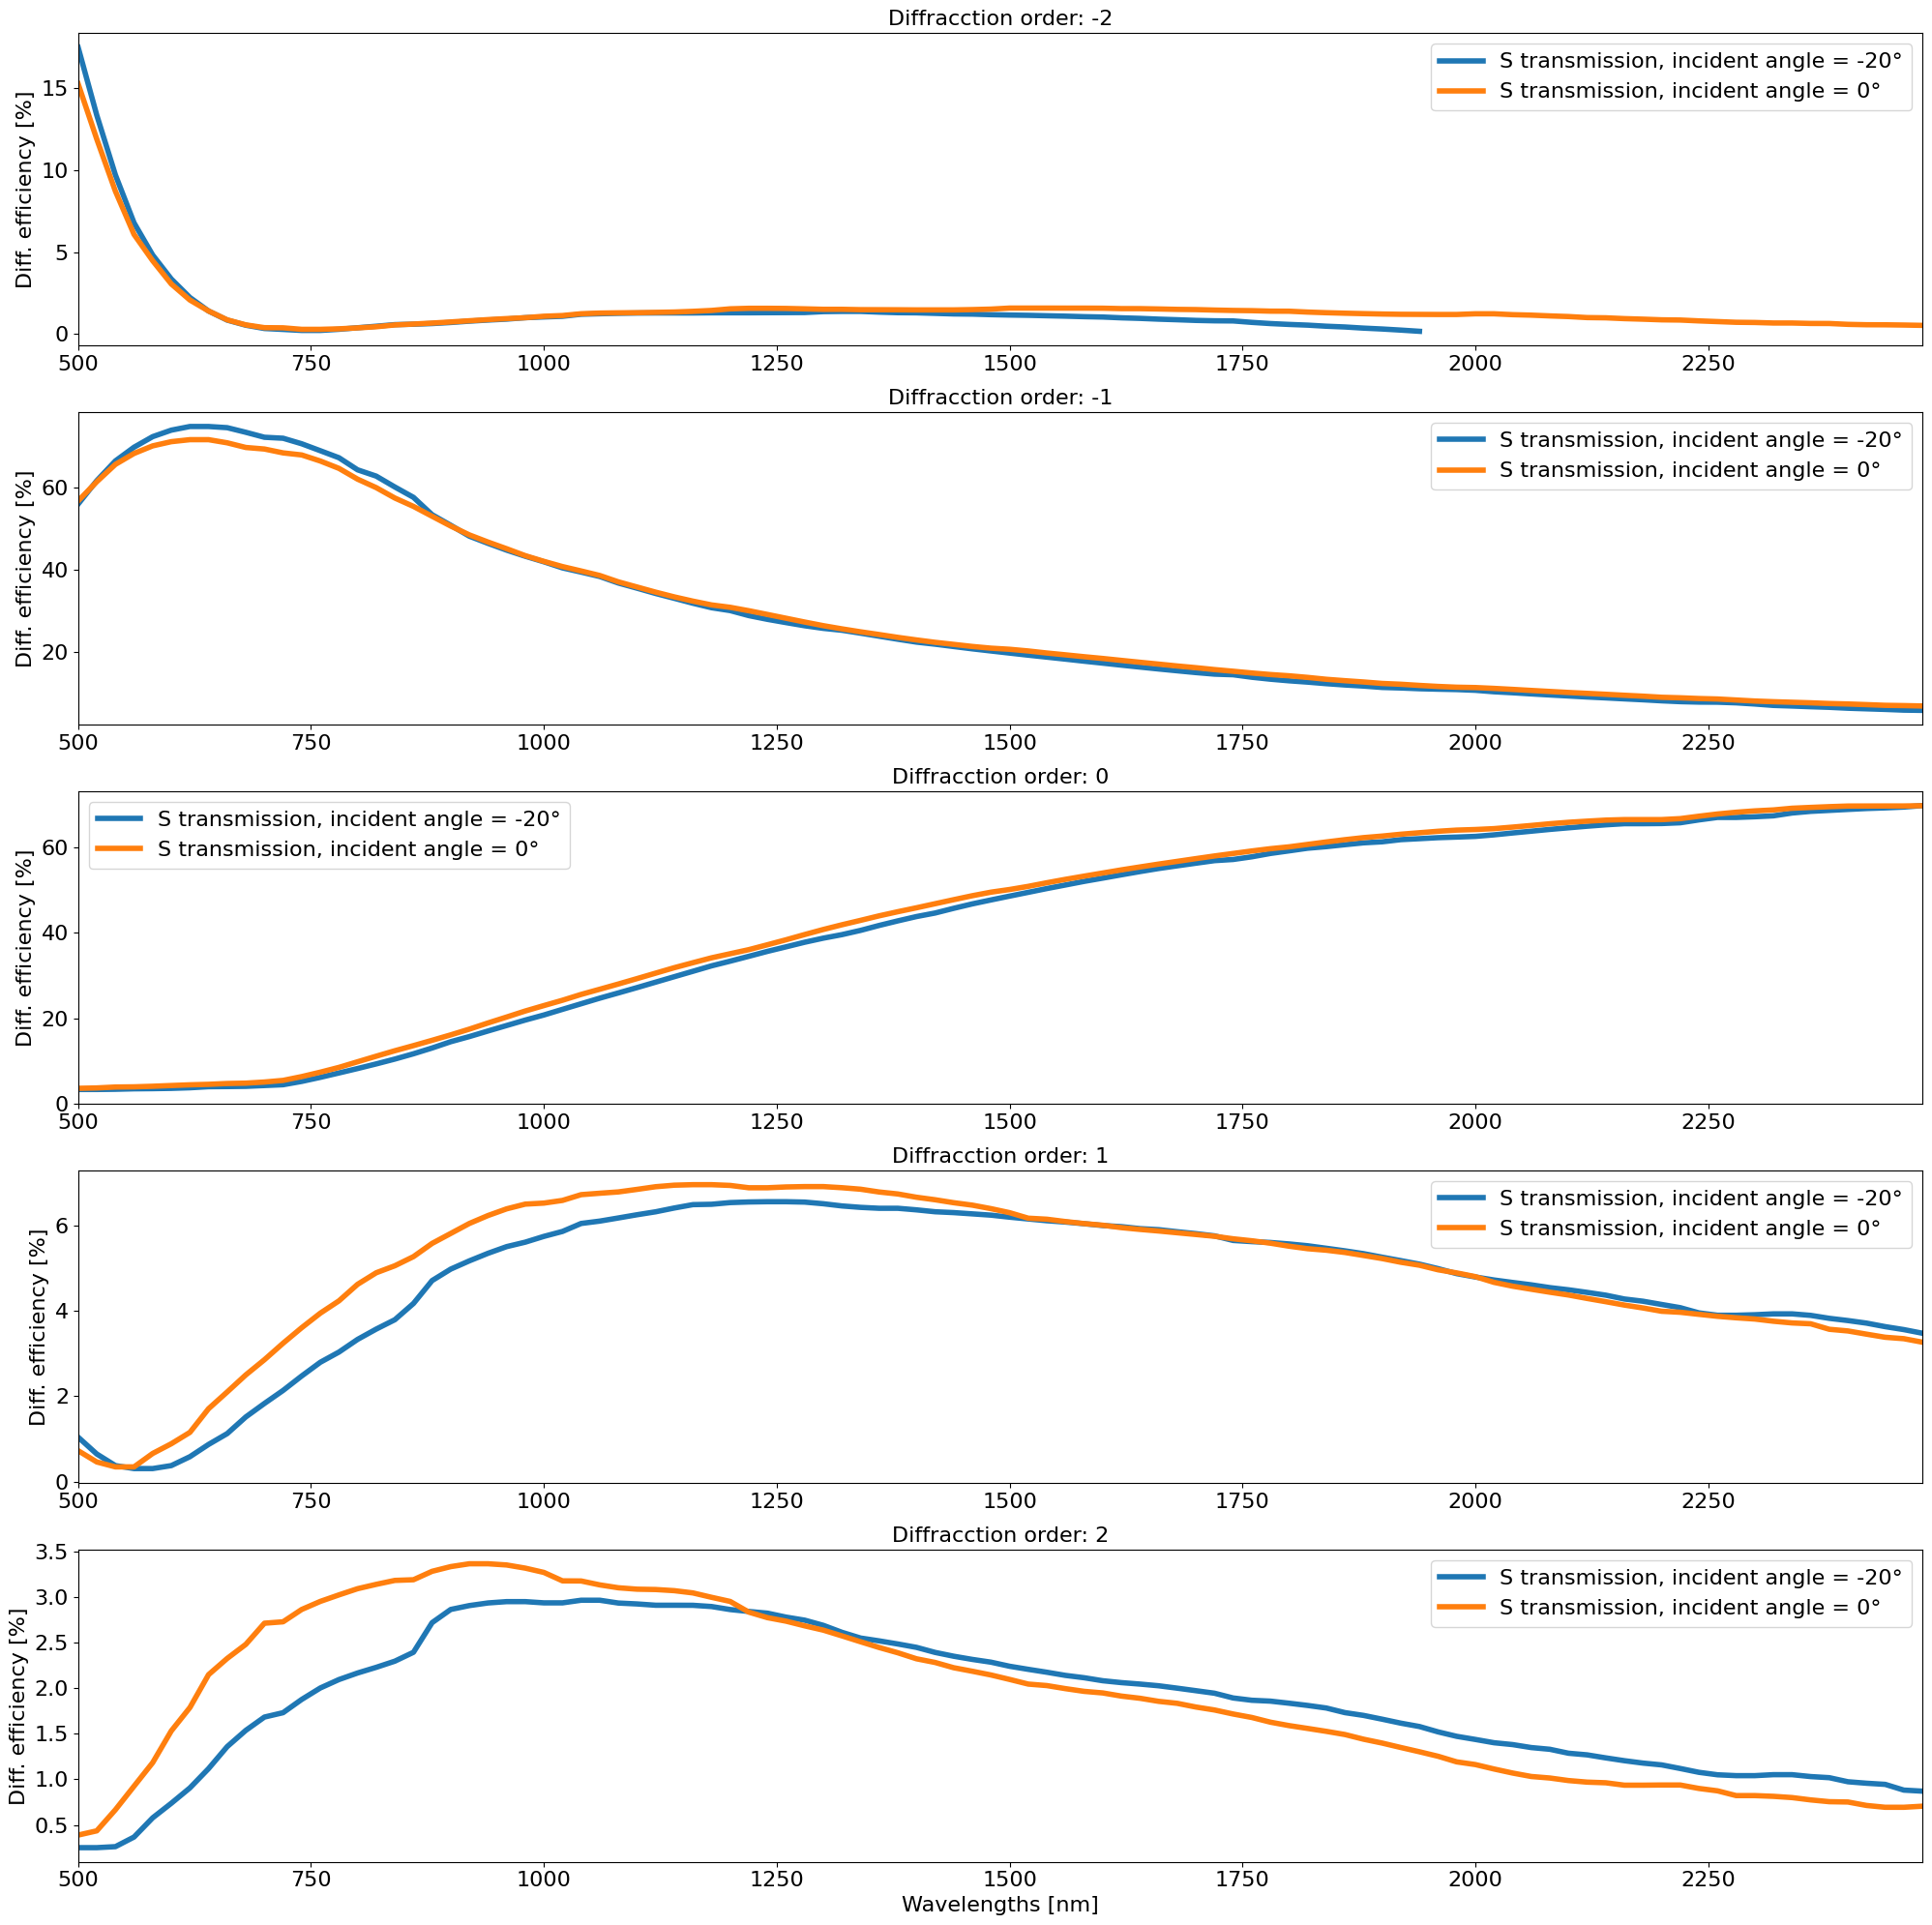

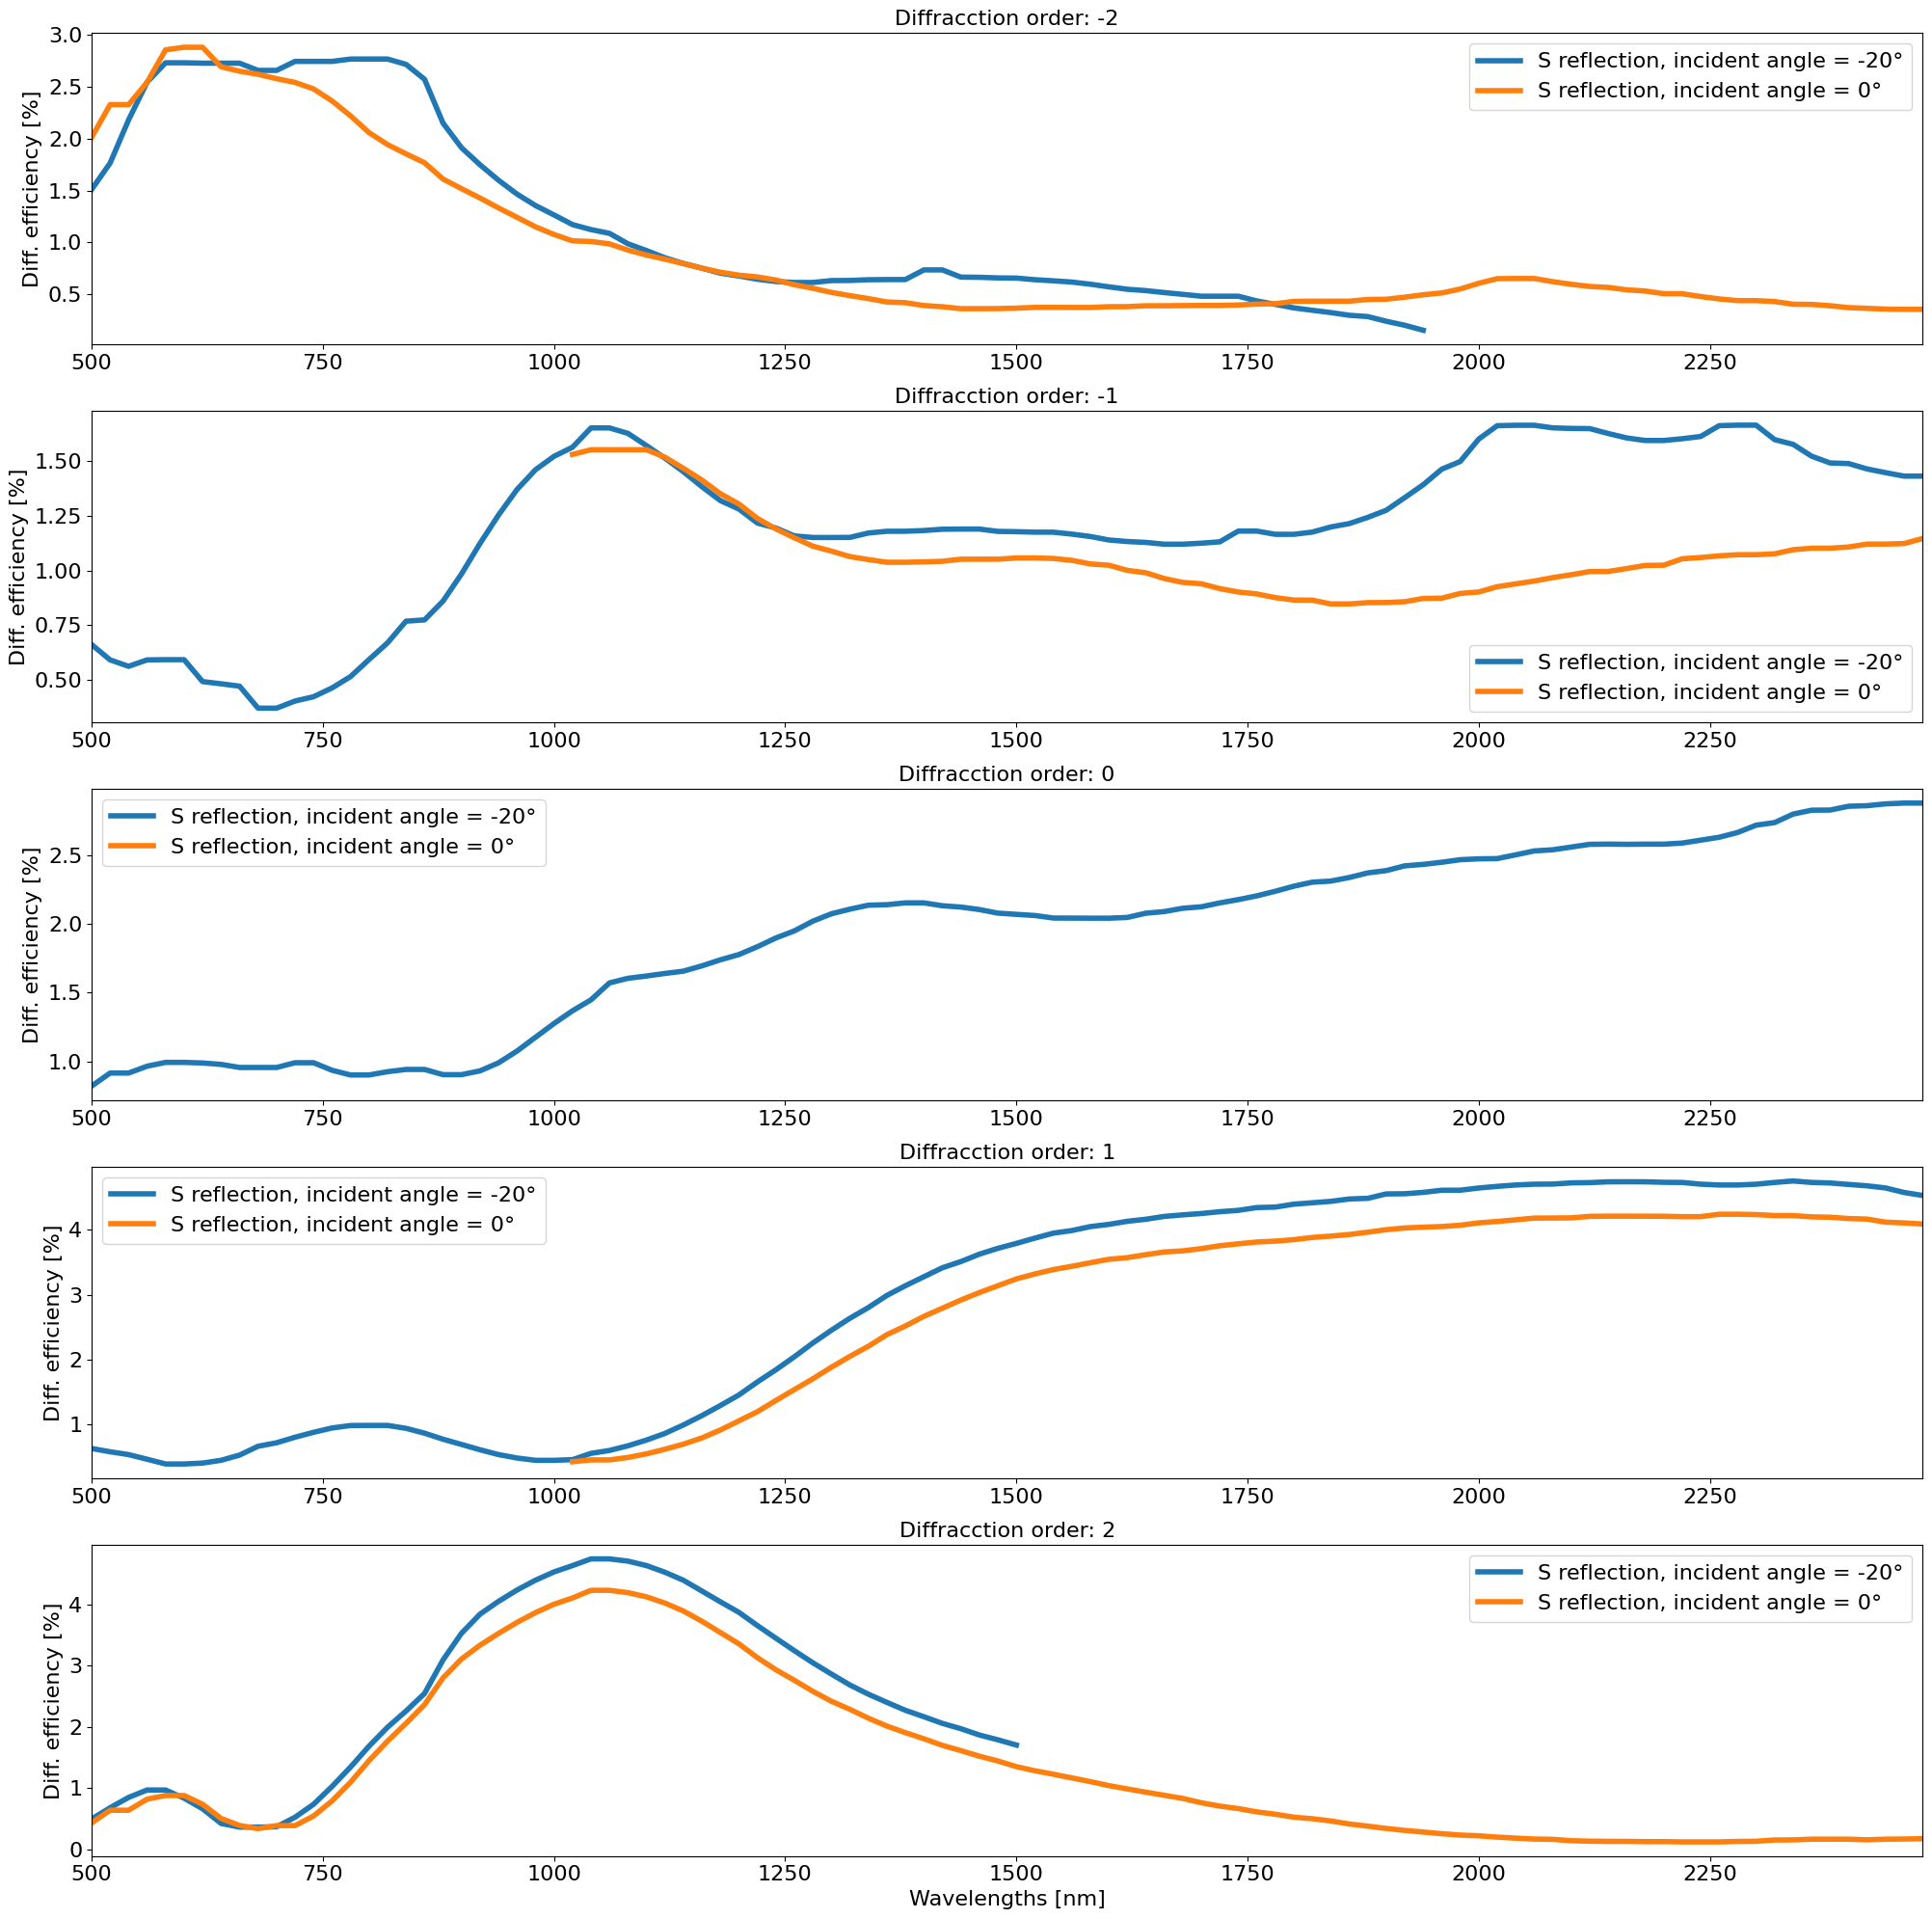

In [9]:
linear_grating.show_envelopes(orders = np.arange(-2,3), incident_angles = [-20, 0])
plt.savefig('trans_angle_compare.png')
linear_grating.show_envelopes(orders = np.arange(-2,3), incident_angles = [-20,0], show_trans = False, show_reflx = True)
plt.savefig('reflx_angle_compare.png')

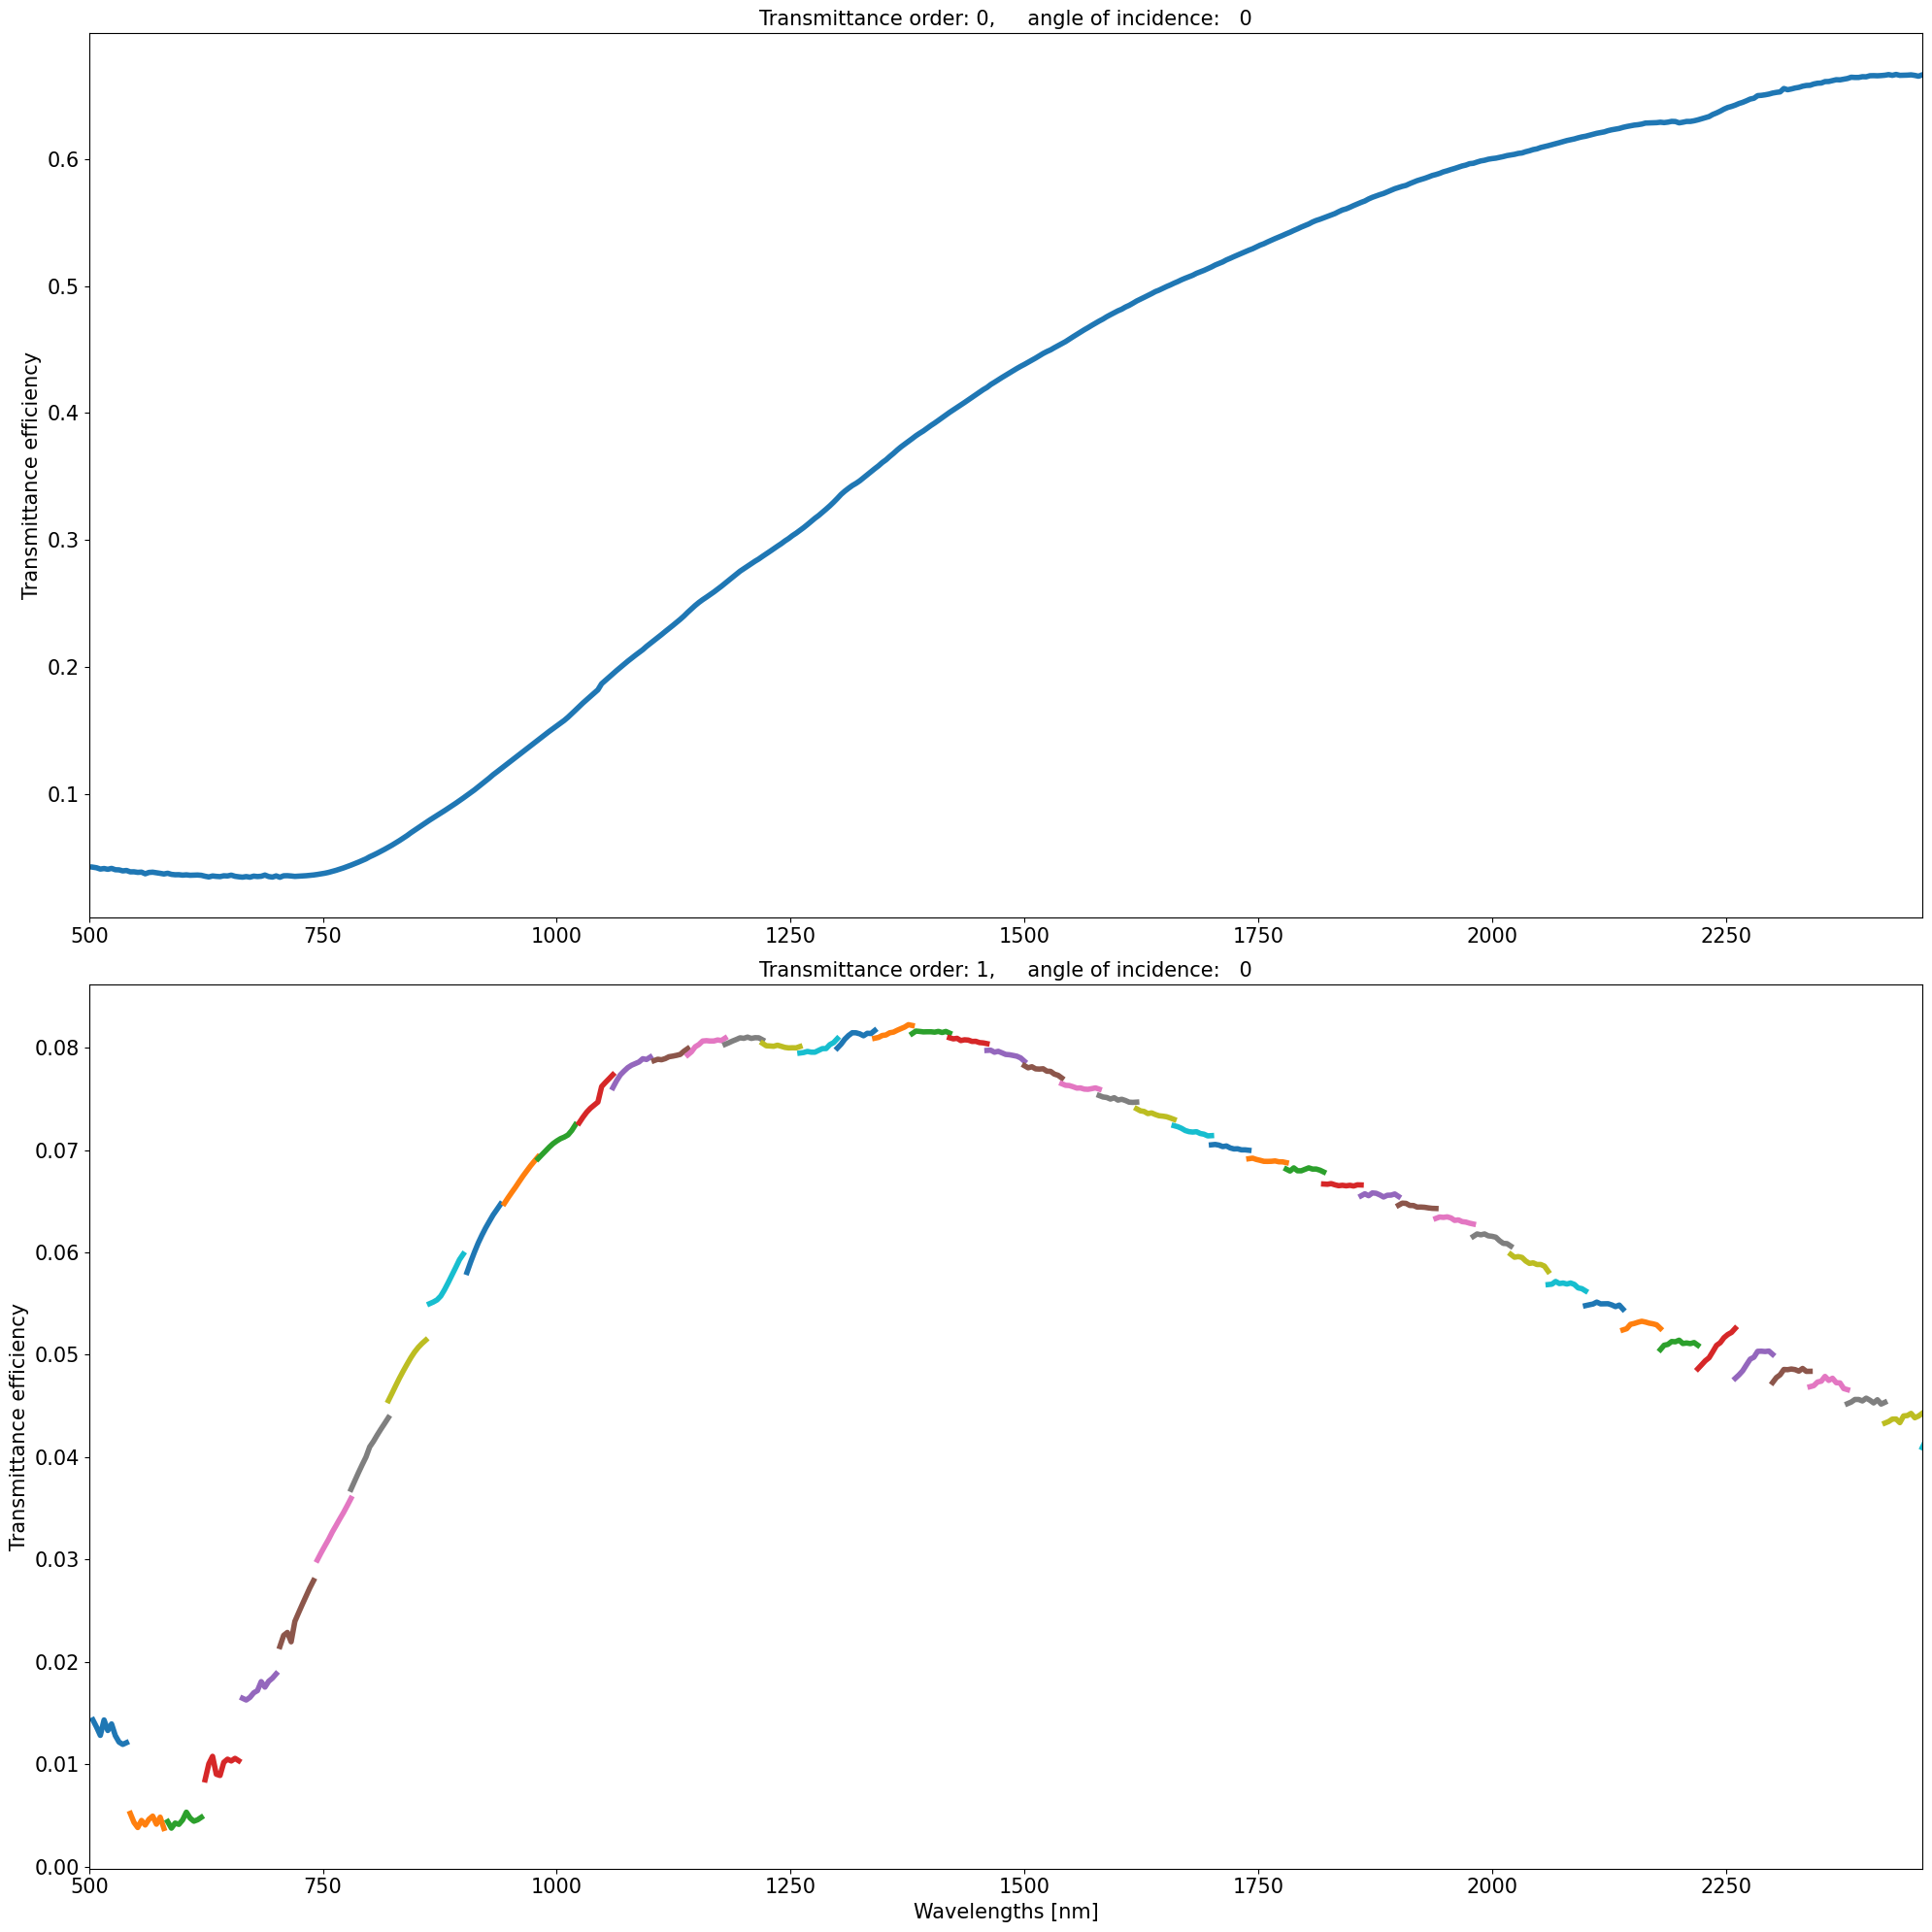

In [10]:
curved_grating.show_peaks(orders = [0, 1], incident_angles = [0], mode= 'trans')
#plt.savefig('show_peaks_example.png')
SMALL_SCANS = curved_grating.data

## Creating animation representing the time saved using my optimization script

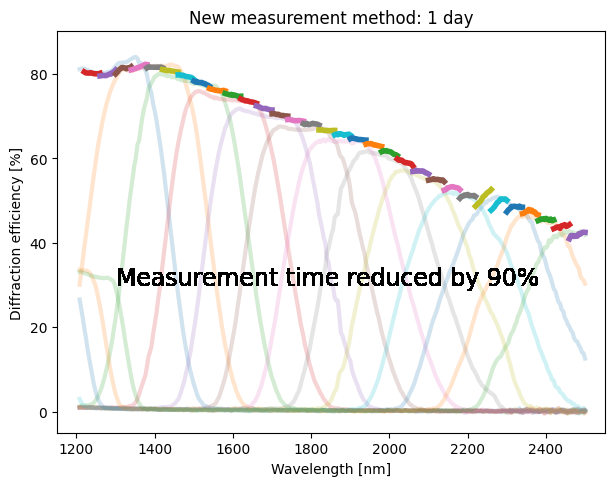

In [11]:
example_df = pd.read_csv('/kaggle/input/example-method/example old method.csv',skiprows=[1], nrows = 324, dtype = float)
small_df = SMALL_SCANS[(SMALL_SCANS['mode'] == 'trans') & (SMALL_SCANS['polarisation'] ==  'S') & (SMALL_SCANS['order'] ==  1) & (SMALL_SCANS['incident_angle'] ==  0)]
try: 
    os.mkdir('figures') 
except:
    print('directory already created')
fig, ax = plt.subplots()

#ax.set_title(sub_frame)
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Diffraction efficiency')
parcelation = 72#18
colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

def update(frame):
    if frame < 12 * parcelation:
        main_frame = 2*int((frame - frame % parcelation)/parcelation)
        sub_frame = frame - int(main_frame/2)*parcelation + 1

        # Iterate over range to plot each series
        pair_df = example_df.iloc[:, [main_frame, main_frame + 1]].dropna()
        pair_df = pair_df.apply(pd.to_numeric, errors='coerce')
        pair_df = pair_df.dropna()
        wavelengths = np.array(pair_df.iloc[:, 0])
        intensity = 10 * np.array(pair_df.iloc[:, 1])
        index = int(sub_frame*324/parcelation)
        color_index = int(main_frame/2%len(colors))
        ax.set_xlabel('Wavelength [nm]')
        ax.set_ylabel('Diffraction efficiency [%]')
        ax.set_title('Old meaurement method: 1 month')   
        ax.set_xlim(1150,2550)
        ax.set_ylim(-5,90)
        ax.plot(wavelengths[:index], 0.9* intensity[:index]*100, linewidth=3, color = colors[color_index])
    if frame == 12*parcelation:
        ax.clear()
        for start_col in range(2,28,2):
            pair_df = example_df.iloc[:, [start_col, start_col+1]].dropna()  # Drop NaN values which are non-numeric rows
            pair_df = pair_df.apply(pd.to_numeric, errors='coerce')
            pair_df = pair_df.dropna()
            wavelengths = np.array(pair_df.iloc[:, 0])
            intensity = np.array(pair_df.iloc[:, 1])
            ax.plot(wavelengths, 0.9* intensity*1000, linewidth = 3, alpha = 0.2)
            ax.set_xlabel('Wavelength [nm]')
            ax.set_ylabel('Diffraction efficiency [%]')
            ax.set_xlim(1150,2550)
            ax.set_ylim(-5,90)
    if frame > 12*parcelation and frame < 12*parcelation+33:
        i = frame - 12 * parcelation + 17
        row = small_df.iloc[i]
        if np.any(row['wavelengths'] > 1200):
            ax.plot(row['wavelengths'], row['intensity']*1000, linewidth = 4)
            ax.set_xlabel('Wavelength [nm]')
            ax.set_ylabel('Diffraction efficiency [%]')
            ax.set_title('New measurement method: 1 day')
            ax.set_xlim(1150,2550)
            ax.set_ylim(-5,90)
    if frame > 12*parcelation+33:
        ax.text(1300, 30, 'Measurement time reduced by 90%', fontsize=17, color='black')
        
        
fig.tight_layout()

# Create animation
ani = FuncAnimation(fig, update, frames=range(0, 12 * parcelation + 33 + 200), repeat=False)

# Save the animation with higher quality
ani.save('dynamic_plots.mp4', writer='ffmpeg', fps=60, dpi=300)  # Adjust fps and dpi as needed

plt.show()


## Individual frames for animation in my LaTeX presentation

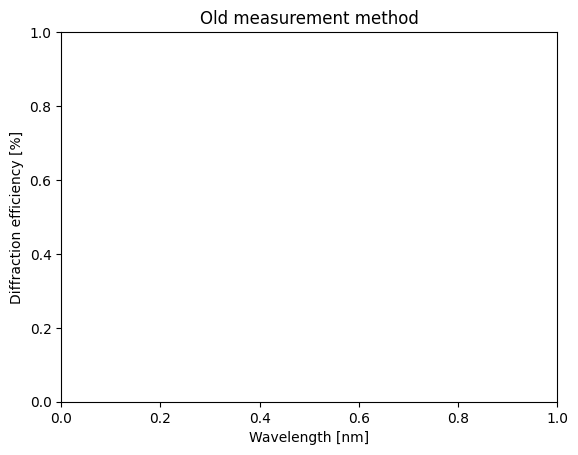

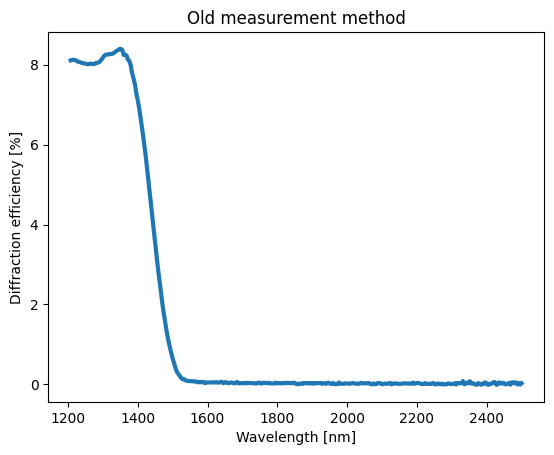

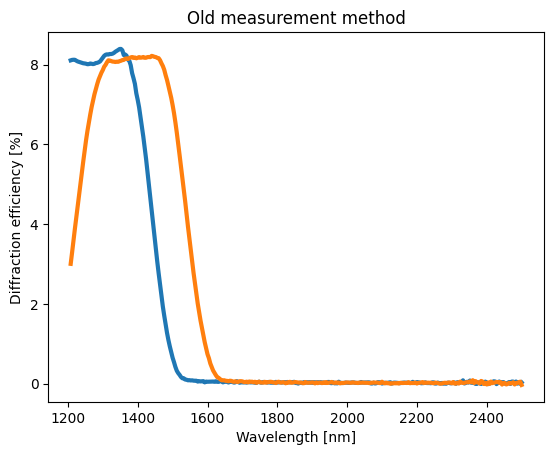

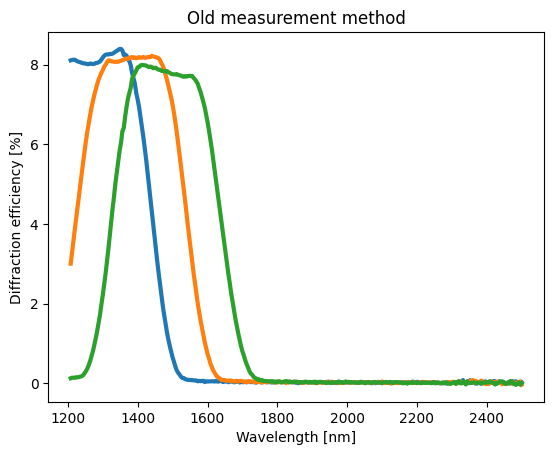

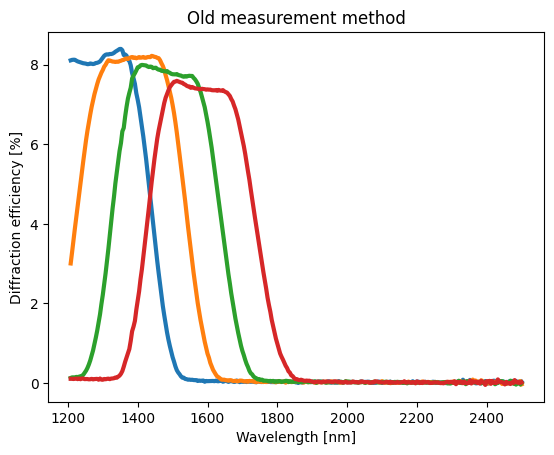

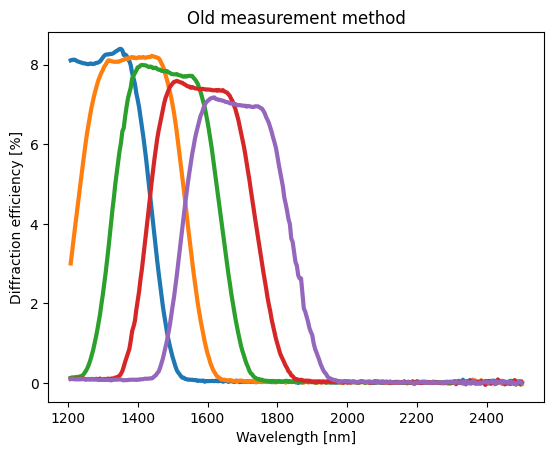

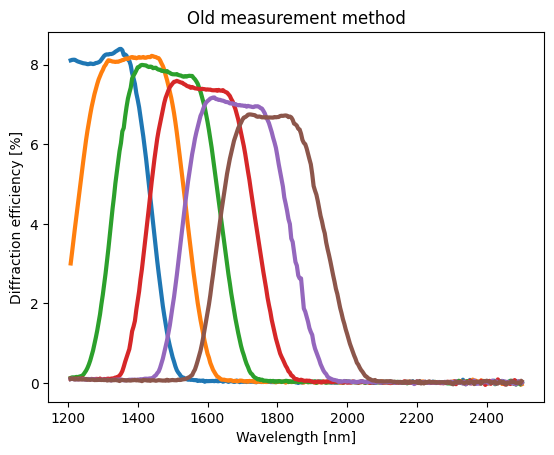

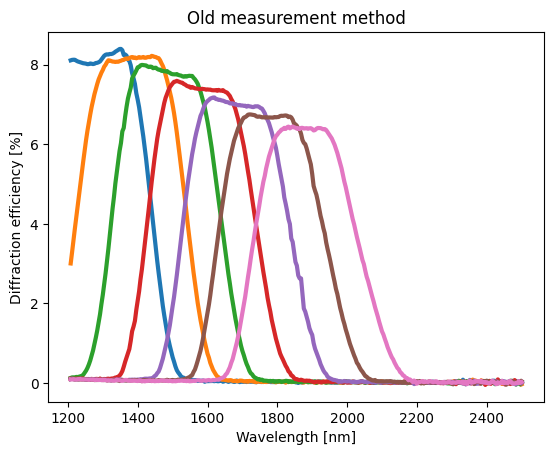

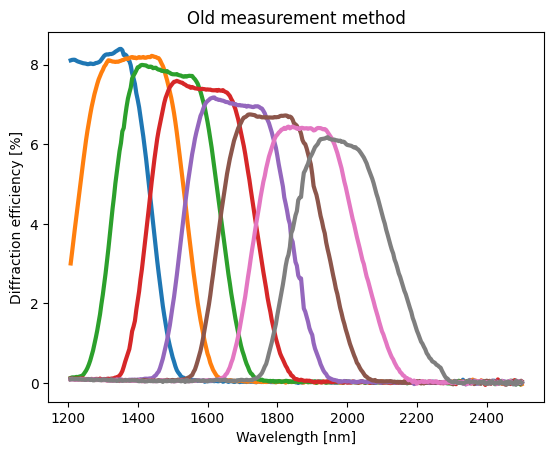

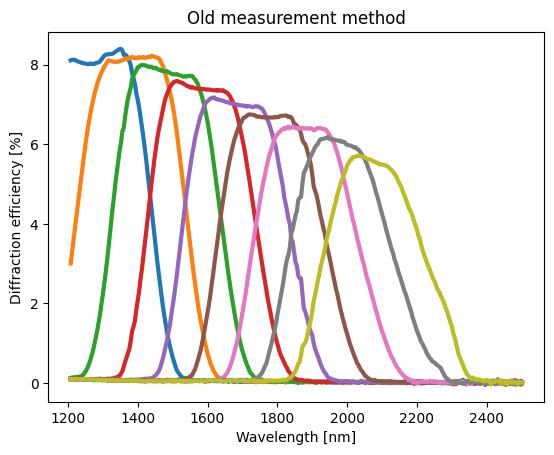

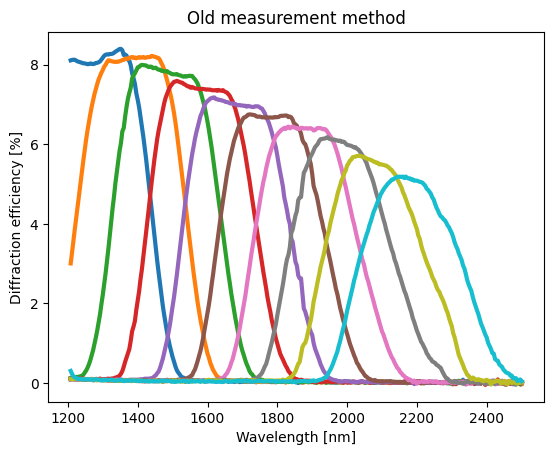

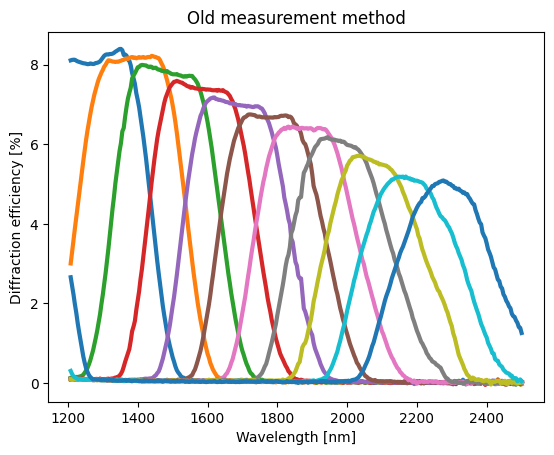

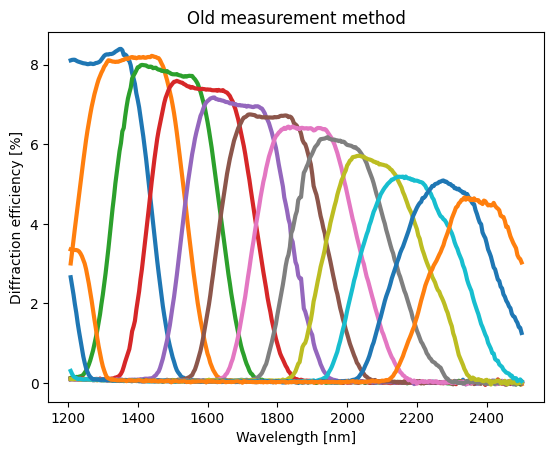

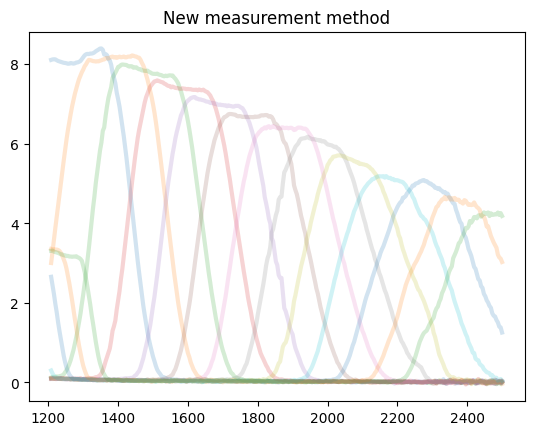

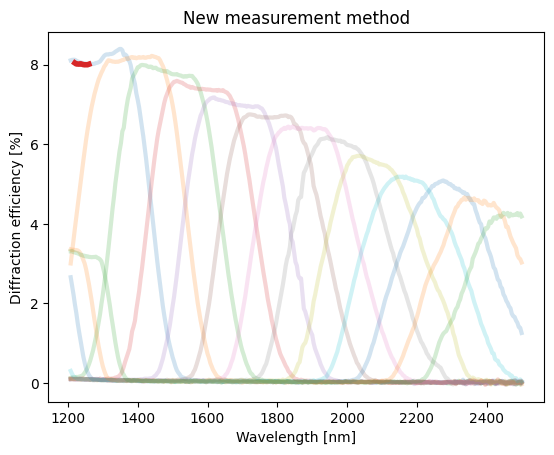

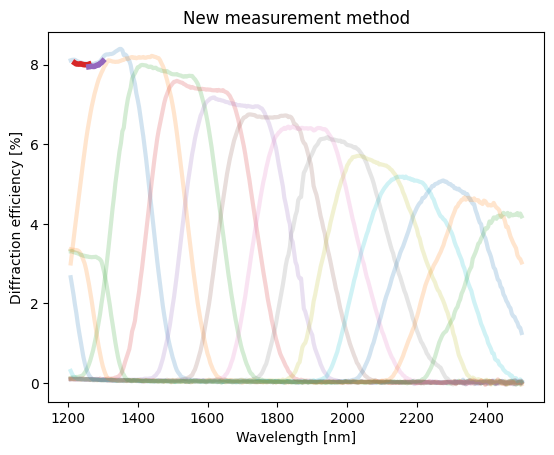

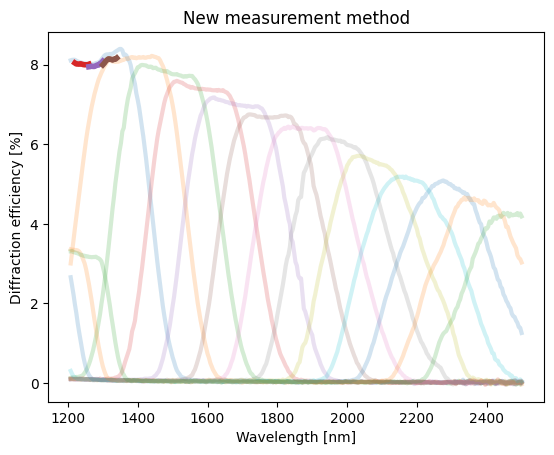

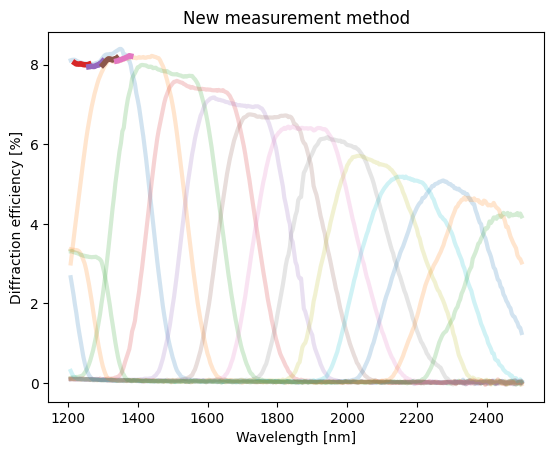

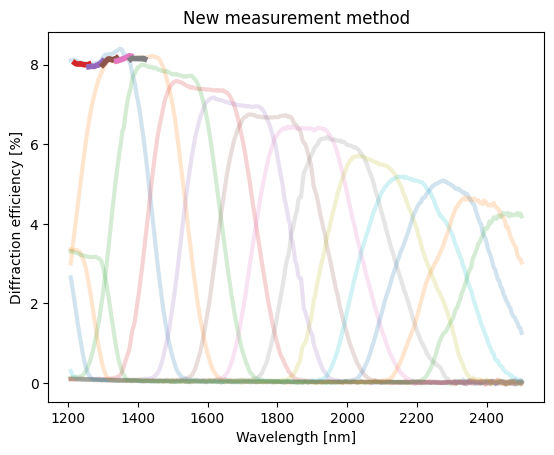

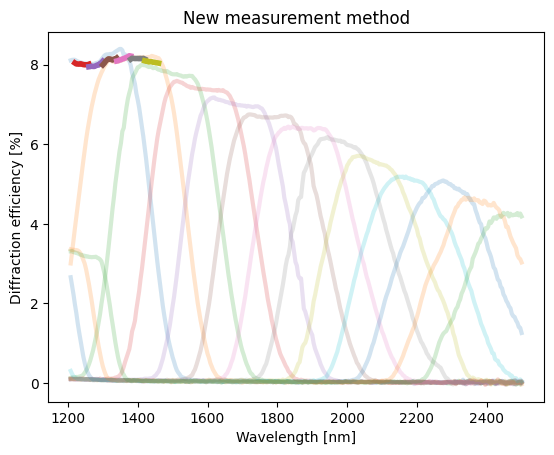

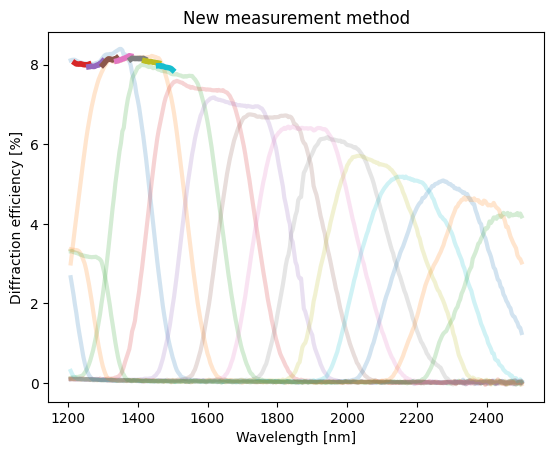

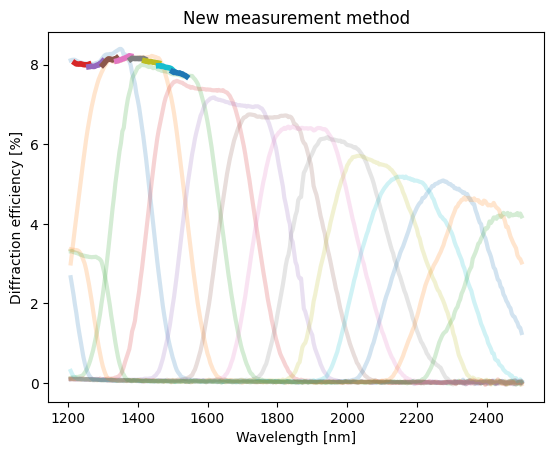

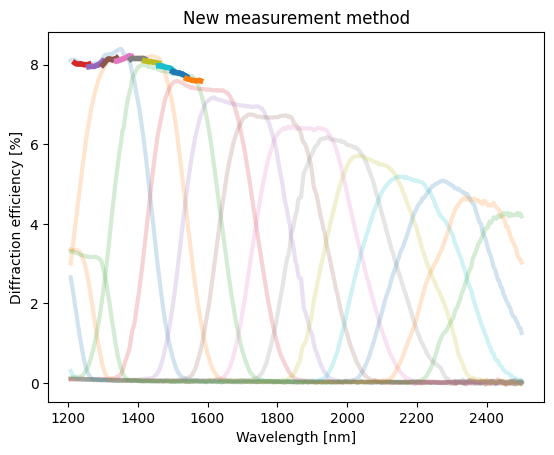

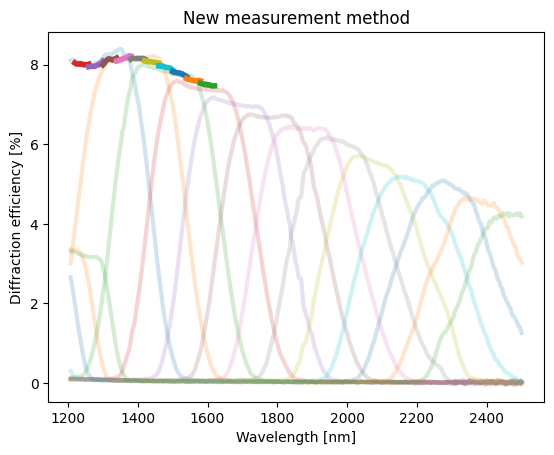

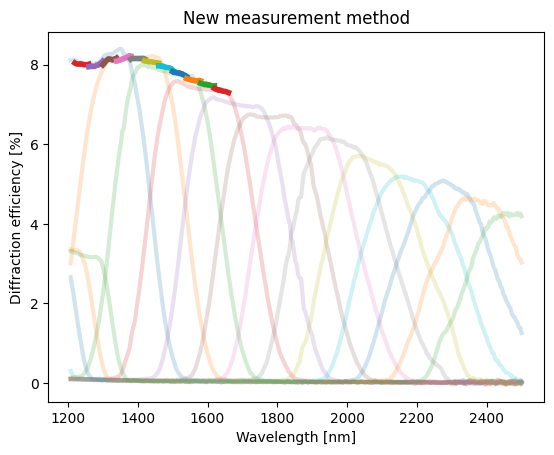

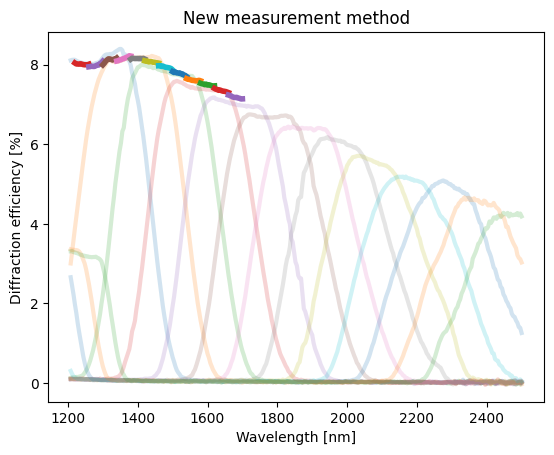

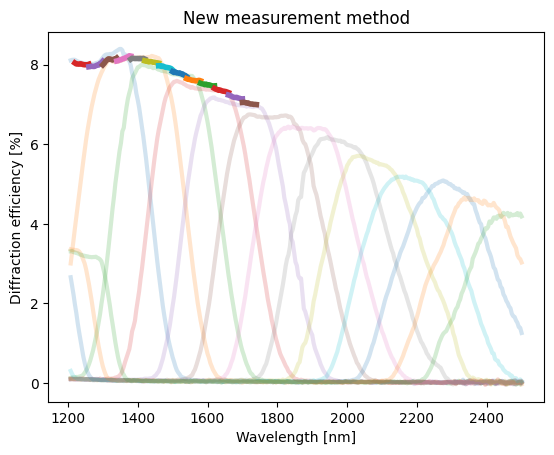

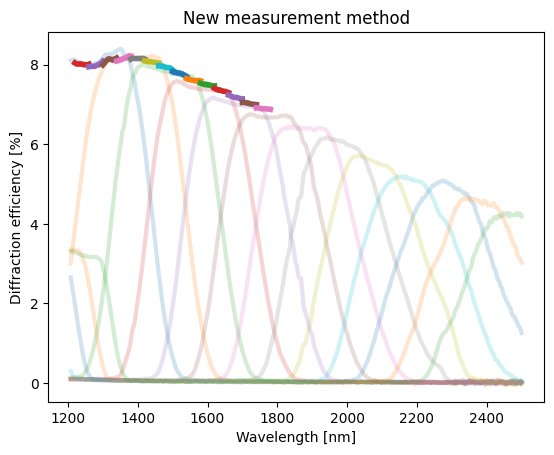

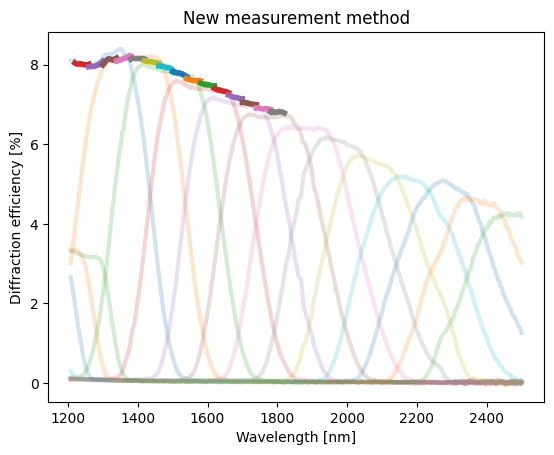

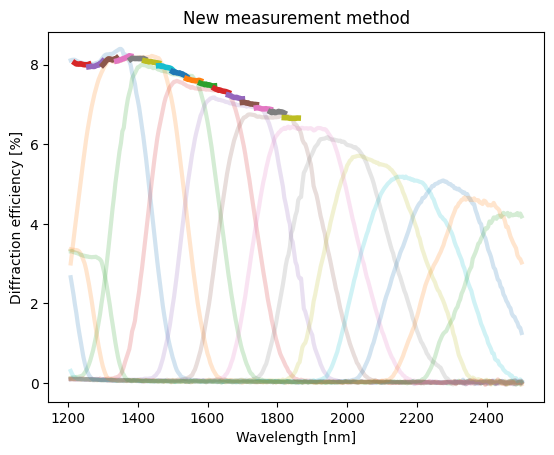

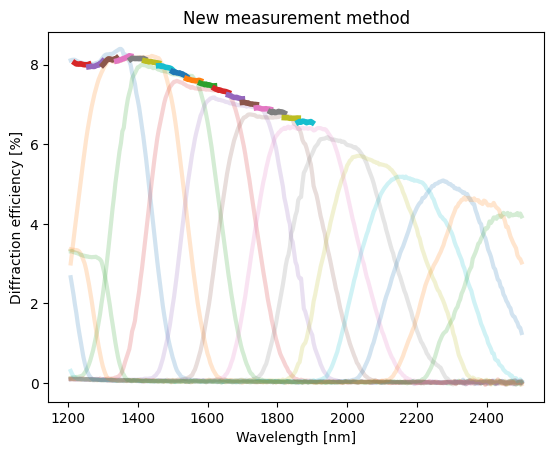

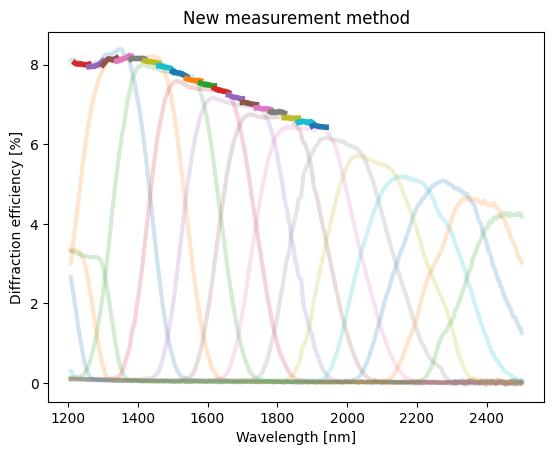

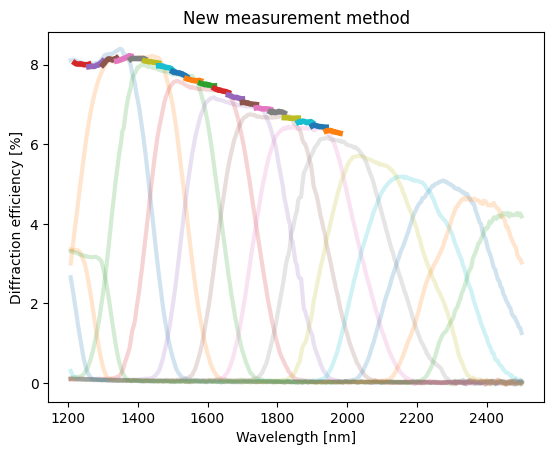

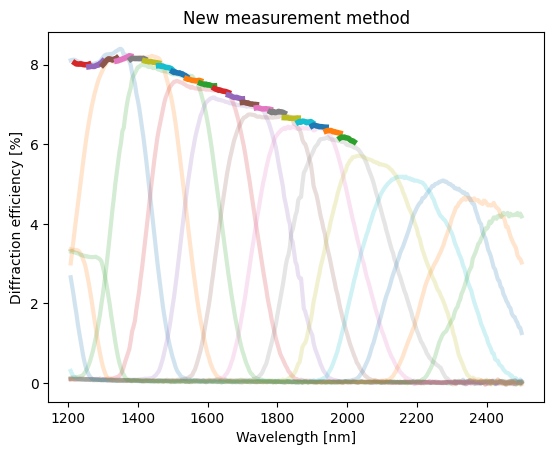

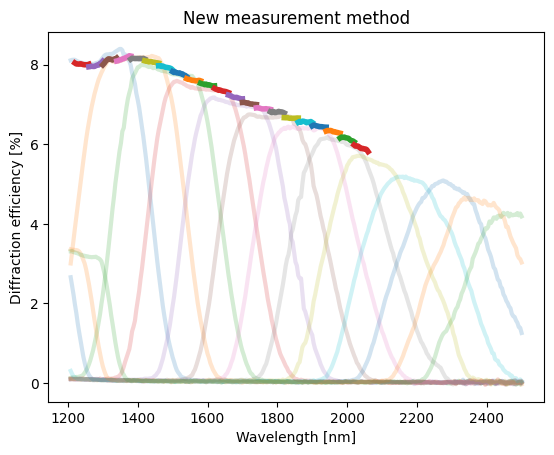

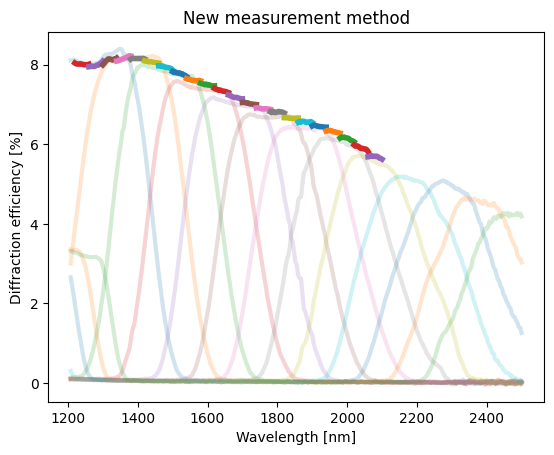

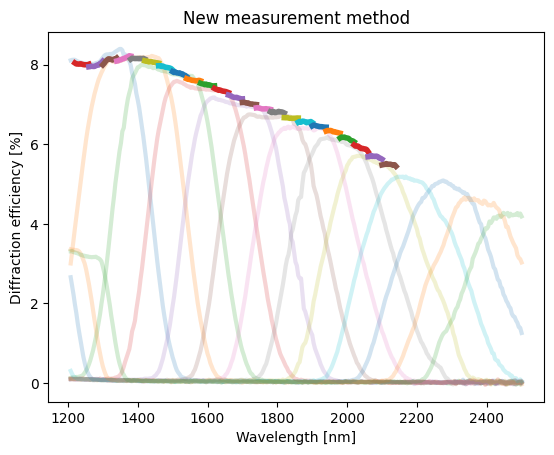

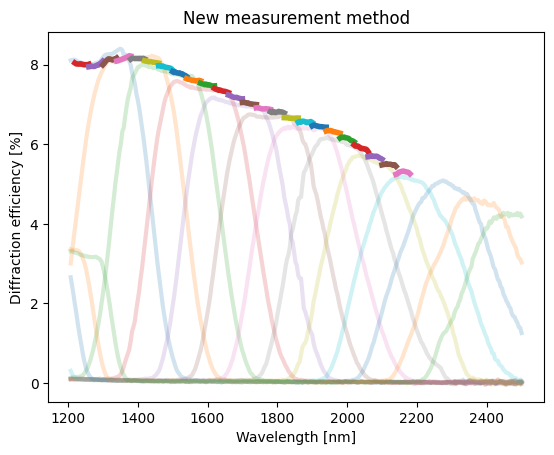

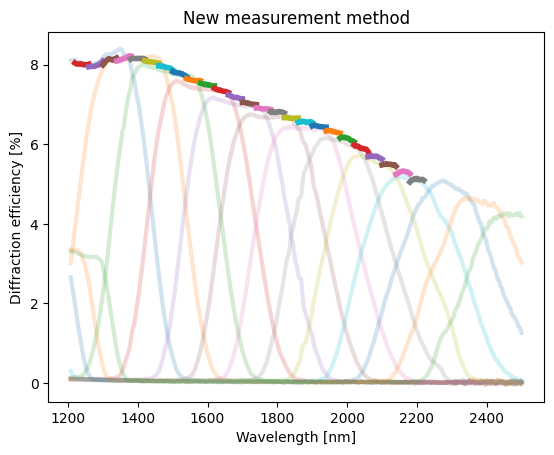

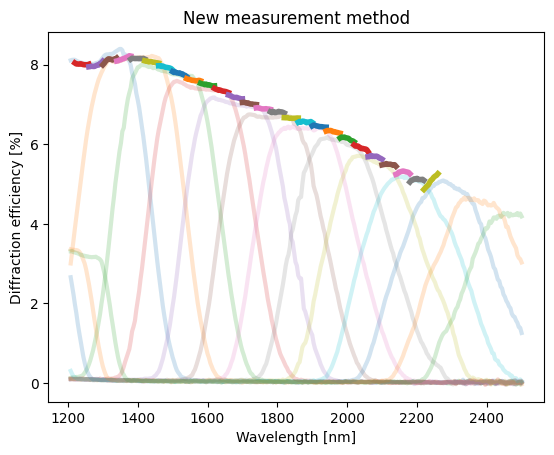

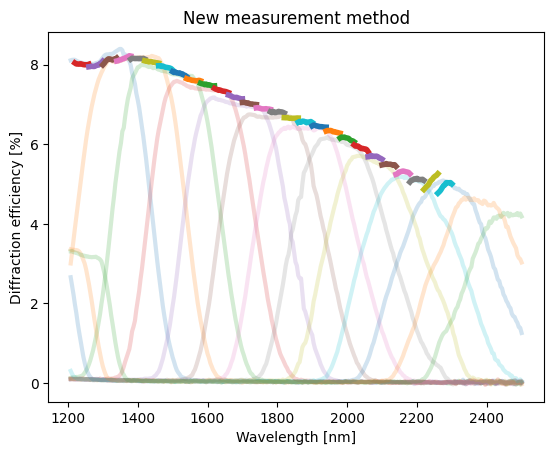

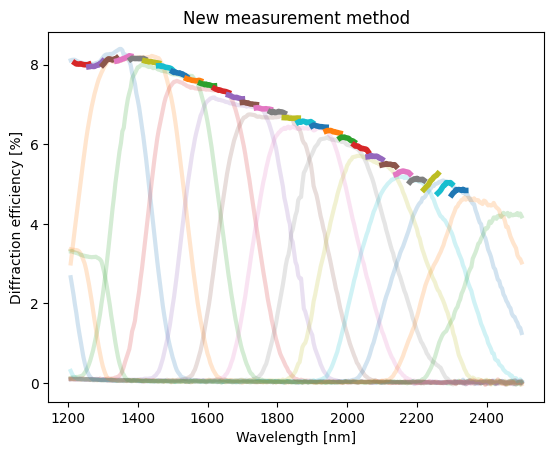

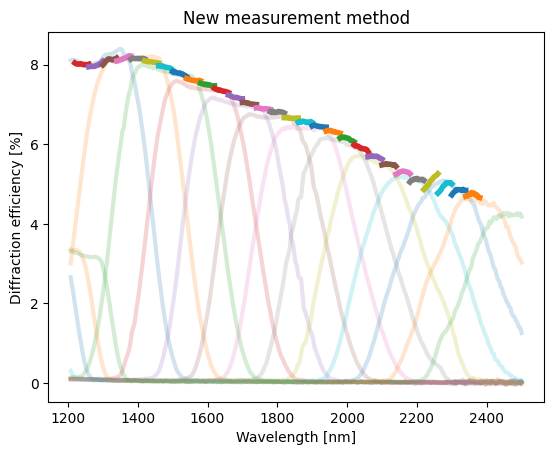

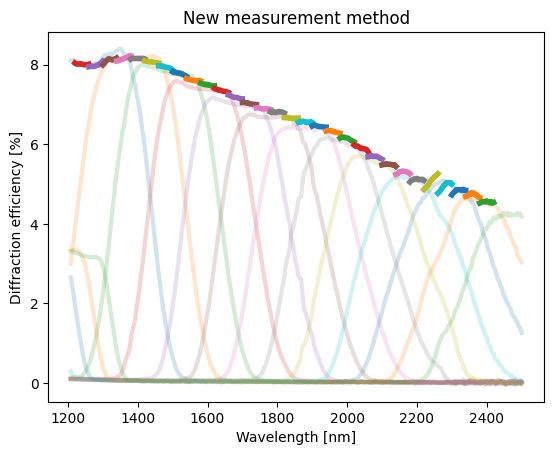

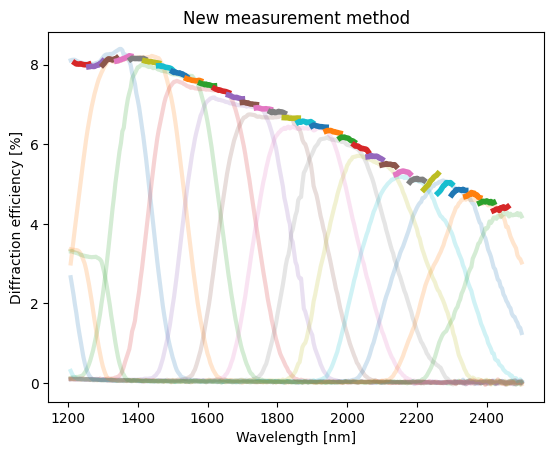

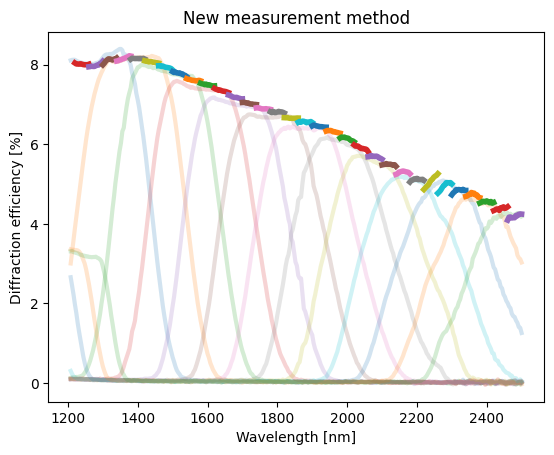

In [12]:
fig, ax = plt.subplots()
No = 0
for stop in range(2,28,2):
    for start_col in range(2,stop,2):
        pair_df = example_df.iloc[:, [start_col, start_col+1]].dropna()  # Drop NaN values which are non-numeric rows
        pair_df = pair_df.apply(pd.to_numeric, errors='coerce')
        pair_df = pair_df.dropna()
        wavelengths = np.array(pair_df.iloc[:, 0])
        intensity = np.array(pair_df.iloc[:, 1])
        plt.plot(wavelengths, 0.9 * intensity * 100, linewidth = 3)
    plt.title('Old measurement method')
    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Diffraction efficiency [%]')
    plt.savefig('figures/'+str(No)+'.png')
    plt.show()
    No += 1
for i in range(18,51, 1):
    plt.title('New measurement method')
    for start_col in range(2,28,2):
        pair_df = example_df.iloc[:, [start_col, start_col+1]].dropna()  # Drop NaN values which are non-numeric rows
        pair_df = pair_df.apply(pd.to_numeric, errors='coerce')
        pair_df = pair_df.dropna()
        wavelengths = np.array(pair_df.iloc[:, 0])
        intensity = np.array(pair_df.iloc[:, 1])
        plt.plot(wavelengths, 0.9*intensity * 100, linewidth = 3, alpha = 0.2)
    restricted_df = small_df.iloc[18:i]
    for index, row in restricted_df.iterrows():
        if np.any(row['wavelengths'] > 1200):
            plt.plot(row['wavelengths'], row['intensity'] * 100, linewidth = 4)
            plt.xlabel('Wavelength [nm]')
            plt.ylabel('Diffraction efficiency [%]')
    plt.savefig('figures/'+str(No)+'.png')
    plt.show()
    No += 1

## Data processing before model fitting

In [13]:
substrate_file_path = '/kaggle/input/substrate/09_23/substrate.csv'
substrate_df = pd.read_csv(substrate_file_path, usecols = [6,7,11], nrows = 665, skiprows = [0])
substrate_df = substrate_df[substrate_df['Wavelength (nm).3'] % 20 == 0]
s_substrate = np.array(substrate_df['%T.3'])
p_substrate = np.array(substrate_df['%T.5'])
linear_s = linear_grating.measured_s_trans[1][1:-1]/s_substrate
linear_p = linear_grating.measured_p_trans[1][1:-1]/p_substrate
linear = np.concatenate((linear_s.flatten(), linear_p.flatten()))

substrate_file_path = '/kaggle/input/substrate/09_23/substrate.csv'
substrate_df = pd.read_csv(substrate_file_path, usecols = [6,7,11], nrows = 665, skiprows = [0])
substrate_df = substrate_df[substrate_df['Wavelength (nm).3'] % 40 == 0]
s_substrate = np.array(substrate_df['%T.3'])
p_substrate = np.array(substrate_df['%T.5'])
oblique_s = curved_grating.measured_s_trans[0][:,:]/s_substrate
oblique_p = curved_grating.measured_p_trans[0][:,:]/p_substrate
oblique = np.concatenate((oblique_s.flatten(), oblique_p.flatten()))

## Functions used during fitting

In [14]:
def numerical_objective_function(x_data, height, power_a, power_b):
    model = DiffractionNumerical(x_data, np.arange(-2, 3), 6_000, height=height, power_a=power_a, power_b=power_b, fill_factor=1)
    model_s, model_p = model.model_s_trans[::-1], model.model_p_trans[::-1]
    model = np.concatenate((model_s.flatten(), model_p.flatten()))
    return model

def numerical_not_objective_function(x_data, height, power_a, power_b):
    model = DiffractionNumerical(x_data, np.arange(-2, 3), 6_000, height=height, power_a=power_a, power_b=power_b, fill_factor=1)
    model = model.model_s_trans[::-1]
    return model

def simulate_numerical_groove(x, height, power_a, power_b):
    period = 6000e-9
    x_private = x/period
    y = x_private**power_a - x_private**power_b
    curve_maxima = (power_b/power_a)**(power_a/(power_a-power_b)) - (power_b/power_a)**(power_b/(power_a-power_b))
    return (1 - y/curve_maxima) * height

def objective_function(x_data, height):
    model = DiffractionAnalytical(x_data, np.arange(-2, 3), [0], 6_000, height=height)
    model_s, model_p = model.model_s_trans[::-1], model.model_p_trans[::-1]
    model = np.concatenate((model_s.flatten(), model_p.flatten()))
    return model

def not_objective_function(x_data, height):
    model = DiffractionAnalytical(np.array(x_data), np.arange(-2, 3), [0], 6_000, height=height)
    model = model.model_s_trans[::]
    return model

def simulate_groove(x, height):
    period = 6000e-9
    height = height*1e-9
    x_private = x/period
    y = -(x_private-period) * height +height
    return y

## Curved grating diffraction efficiencies fitted with numerical model

Fitted parameters: [862.6534041   27.31560081   1.4748459 ]


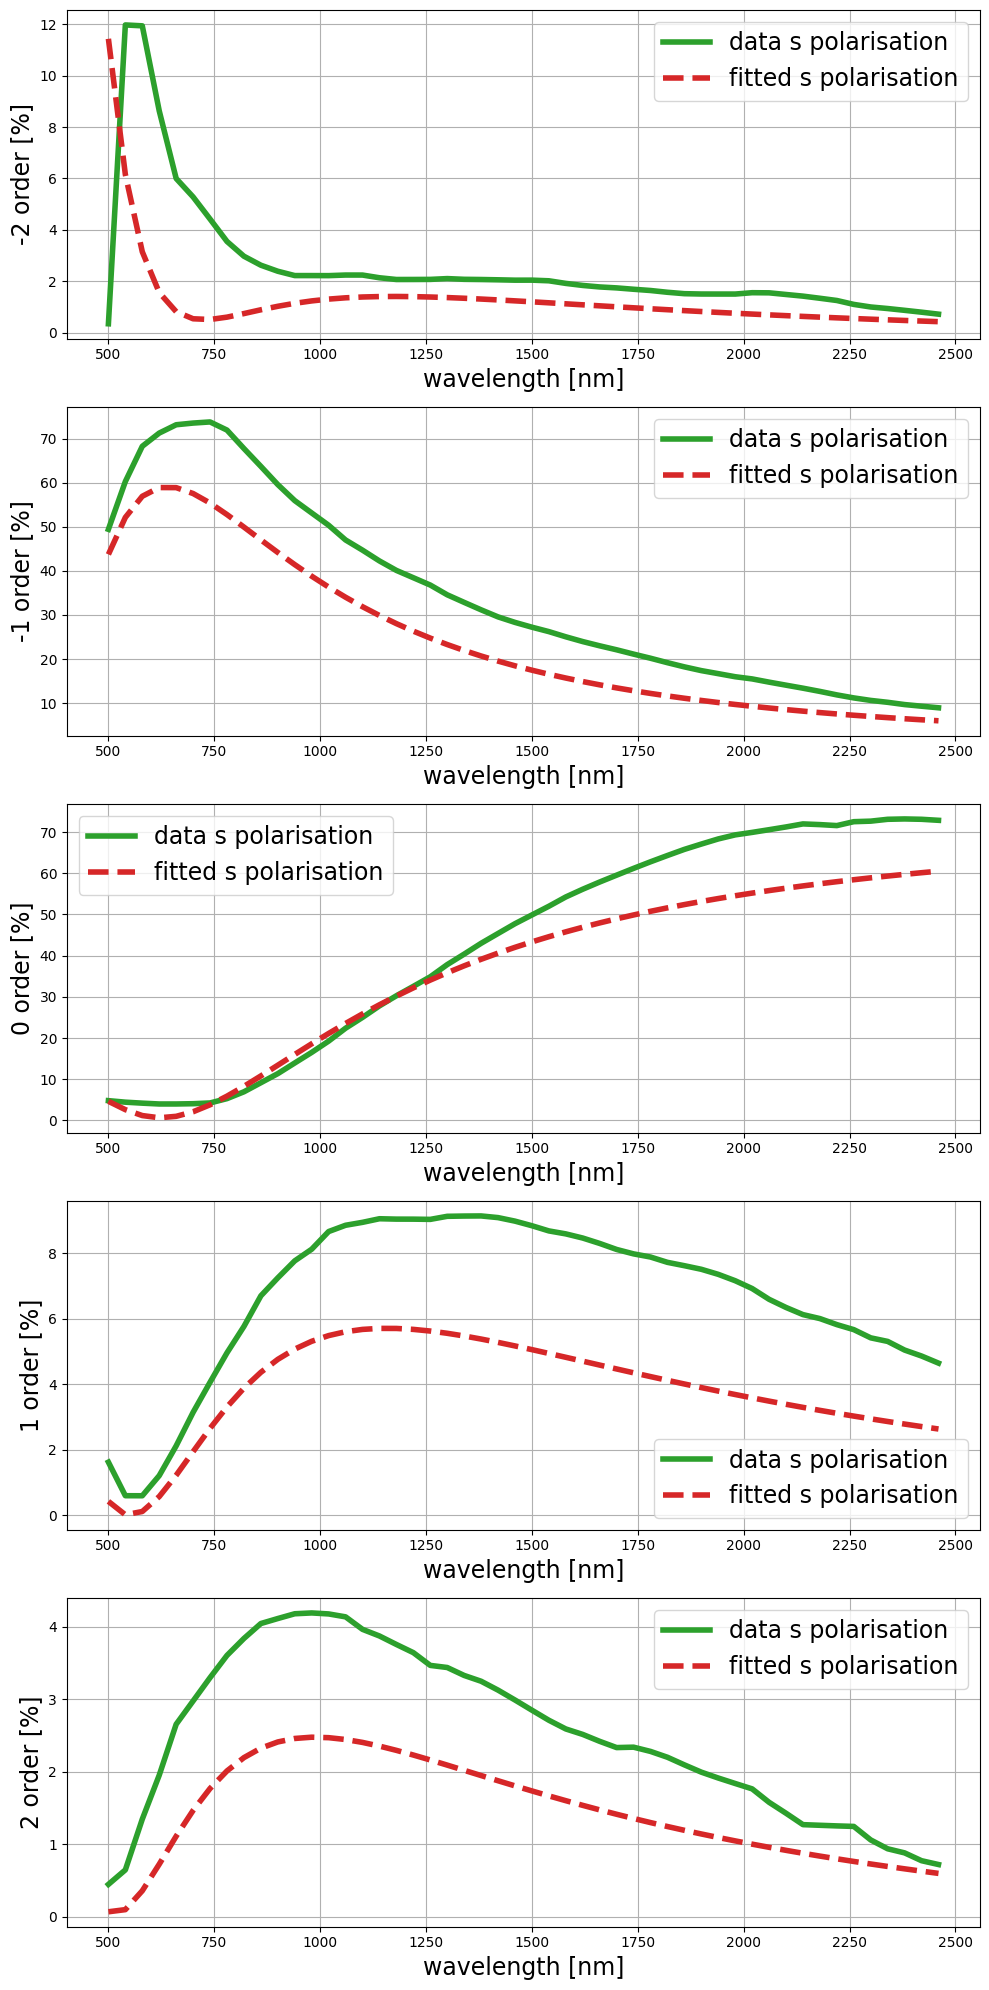

In [15]:
# Example [height, power_a, power_b]
lower_bounds = [0, 1e-6, 1e-6]  
upper_bounds = [1200, 100, 100] 

x_data = np.arange(500,2500,40)
curved_popt, pcov = curve_fit(numerical_objective_function, x_data, oblique, bounds=(lower_bounds, upper_bounds))

print("Fitted parameters:", curved_popt)

y_fitted = numerical_not_objective_function(x_data, *curved_popt)
    
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))
for fit, true ,ax, m in zip(y_fitted, oblique_s, axes, range(-2,3)):
    ax.plot(x_data, true*100, label='data s polarisation', linewidth = 4, color = py_green)
    ax.plot(x_data, fit*100, '--', label='fitted s polarisation', linewidth = 4, color = py_red)
    #ax.set_title(title+' '+ str(incident_angle) +' incident angle in '+ mode, size=22)
    ax.set_xlabel('wavelength [nm]', size = 17)
    ax.set_ylabel(str(m) + ' order [%]', size = 17)
    ax.grid()
    ax.legend(fontsize = 17)
plt.tight_layout()
plt.savefig('numerical_curved.png')

## Curved grating diffraction efficiencies fitted with analytical model

Fitted parameters: [984.84556073]


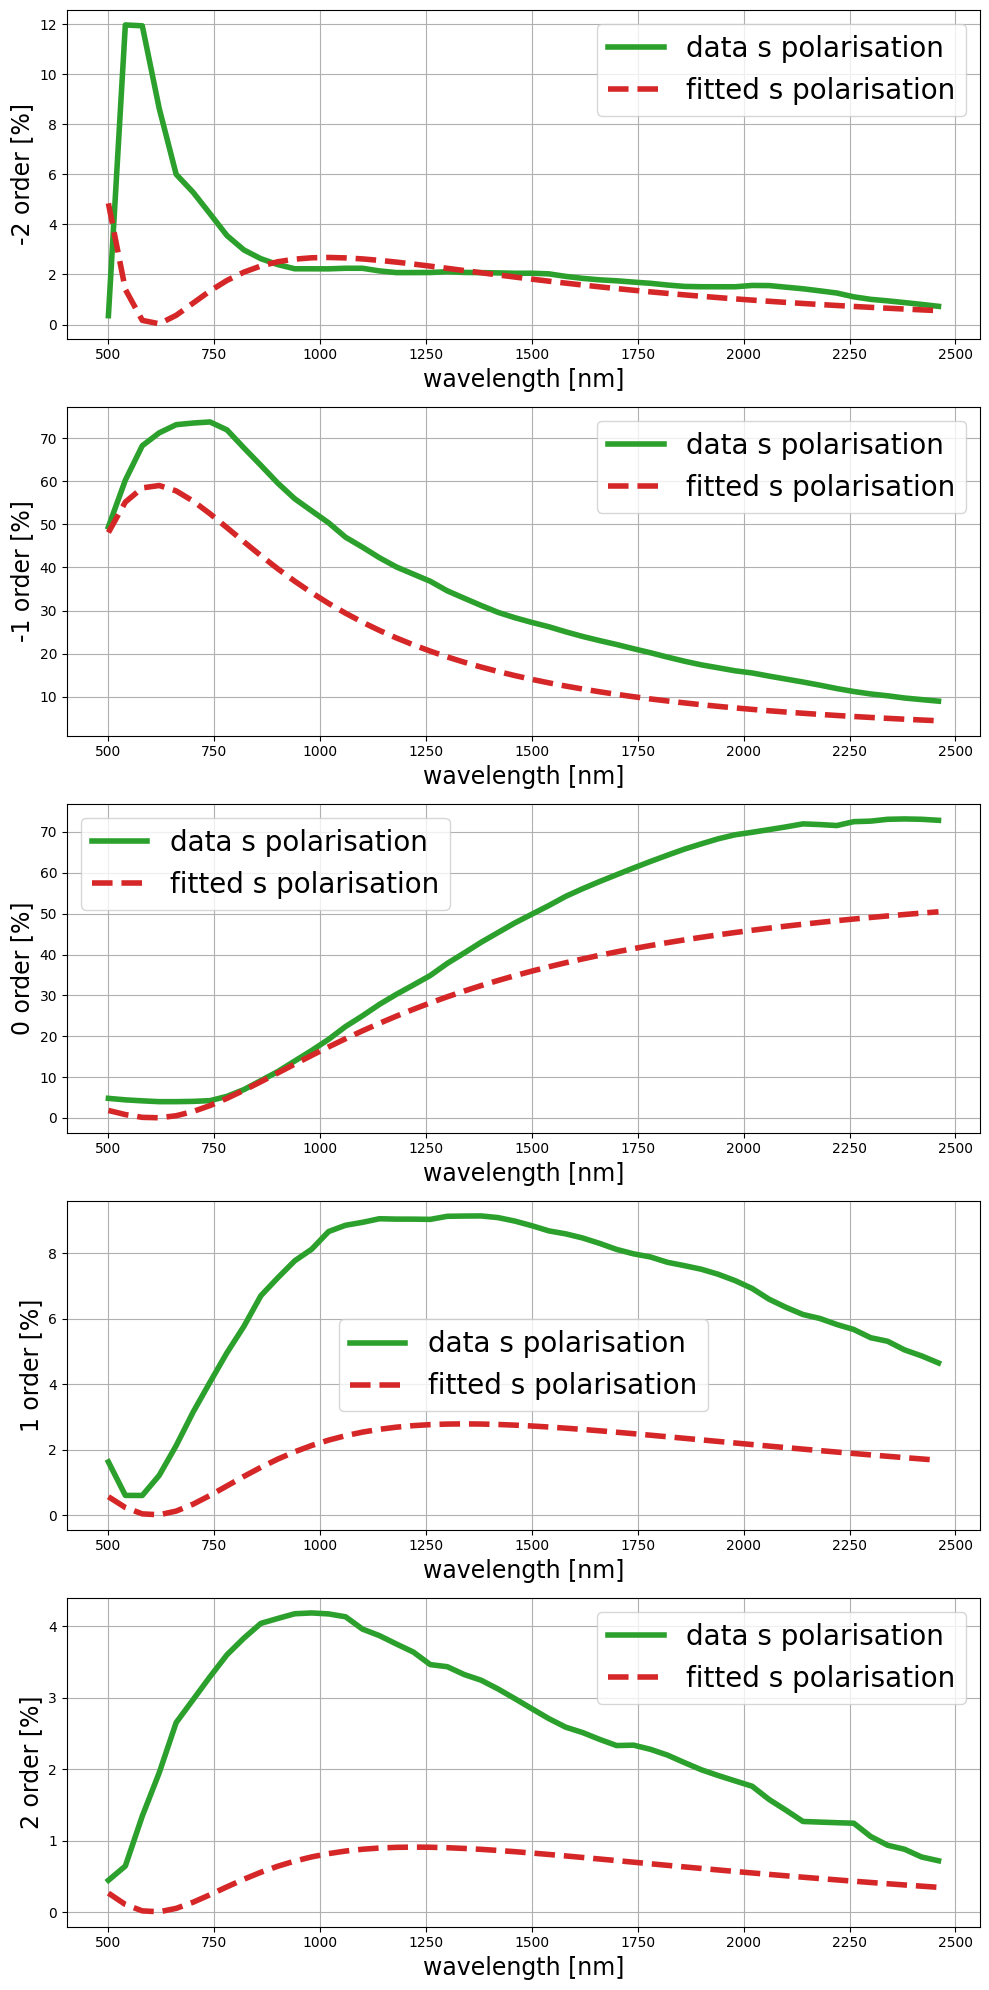

In [16]:
x_data = np.arange(500,2500,40)
# Example [height, power_a, power_b]
lower_bounds = [0]  
upper_bounds = [1200] 

analytic_curved_popt, pcov = curve_fit(objective_function, x_data, oblique, bounds=(lower_bounds, upper_bounds))

print("Fitted parameters:", analytic_curved_popt)

y_fitted = np.squeeze(not_objective_function(x_data, *analytic_curved_popt))
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))
for fit, true ,ax, m in zip(y_fitted, oblique_s, axes, range(-2,3)):
    ax.plot(x_data, true*100, label='data s polarisation', linewidth = 4, color = py_green)
    ax.plot(x_data, fit*100, '--', label='fitted s polarisation', linewidth = 4, color = py_red)
    #ax.set_title(title+' '+ str(incident_angle) +' incident angle in '+ mode, size=22)
    ax.set_xlabel('wavelength [nm]', size = 17)
    ax.set_ylabel(str(m) + ' order [%]', size = 17)
    ax.grid()
    ax.legend(fontsize = 20)
plt.tight_layout()
plt.savefig('analytical_curved.png')

## Linear grating diffraction efficiencies fitted with numerical model

Fitted parameters: [8.82381449e+02 3.75298069e+01 8.37519813e-01]


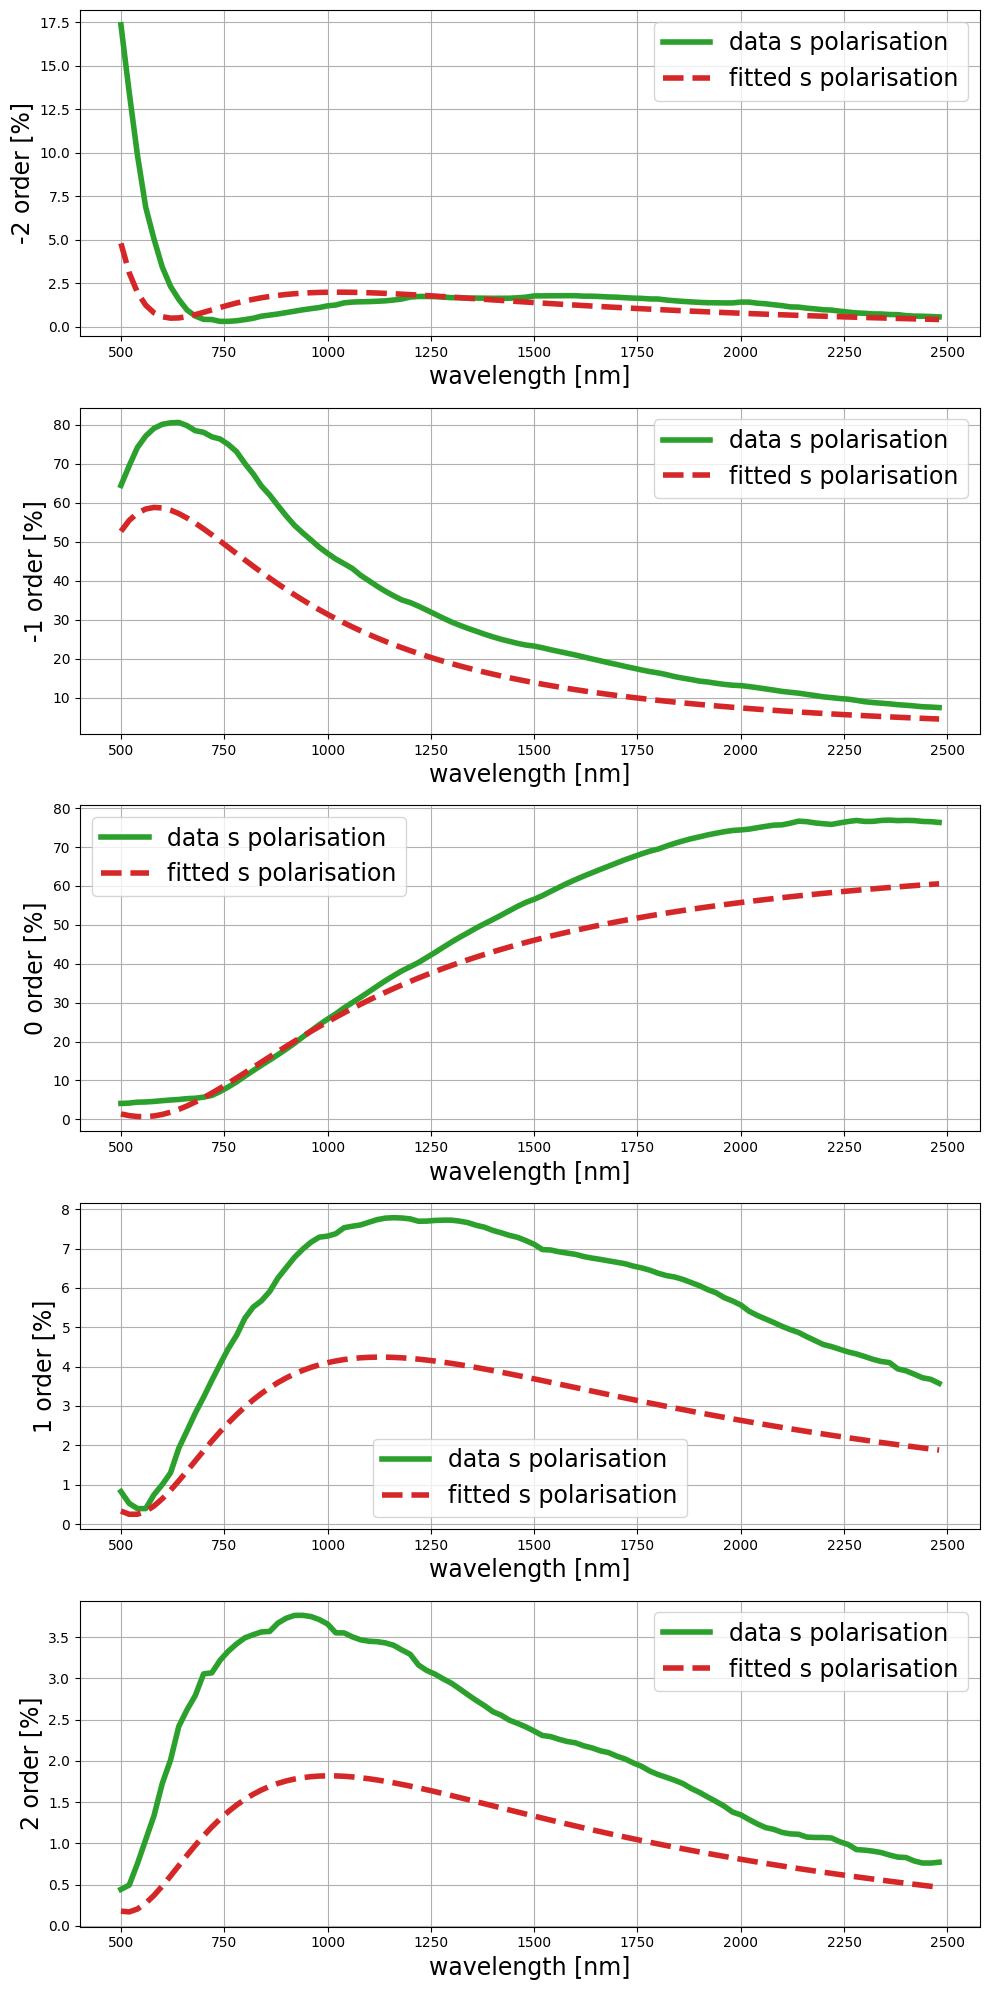

In [17]:
x_data = np.arange(500,2500,20)
# Example [height, power_a, power_b]
lower_bounds = [0, 1e-6, 1e-6]  # Setting realistic lower bounds
upper_bounds = [1200, 100, 100]  # Setting realistic upper bounds

linear_popt, pcov = curve_fit(numerical_objective_function, x_data, linear, bounds=(lower_bounds, upper_bounds))

print("Fitted parameters:", linear_popt)

y_fitted = numerical_not_objective_function(x_data, *linear_popt)
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))
for fit, true ,ax, m in zip(y_fitted, linear_s, axes, range(-2,3)):
    ax.plot(x_data, true*100, label='data s polarisation', linewidth = 4, color = py_green)
    ax.plot(x_data, fit*100, '--', label='fitted s polarisation', linewidth = 4, color = py_red)
    #ax.set_title(title+' '+ str(incident_angle) +' incident angle in '+ mode, size=22)
    ax.set_xlabel('wavelength [nm]', size = 17)
    ax.set_ylabel(str(m) + ' order [%]', size = 17)
    ax.grid()
    ax.legend(fontsize = 17)
plt.tight_layout()
plt.savefig('numerical_linear.png')

## Linear grating diffraction efficiencies fitted with analytical model

Fitted parameters: [893.06860089]


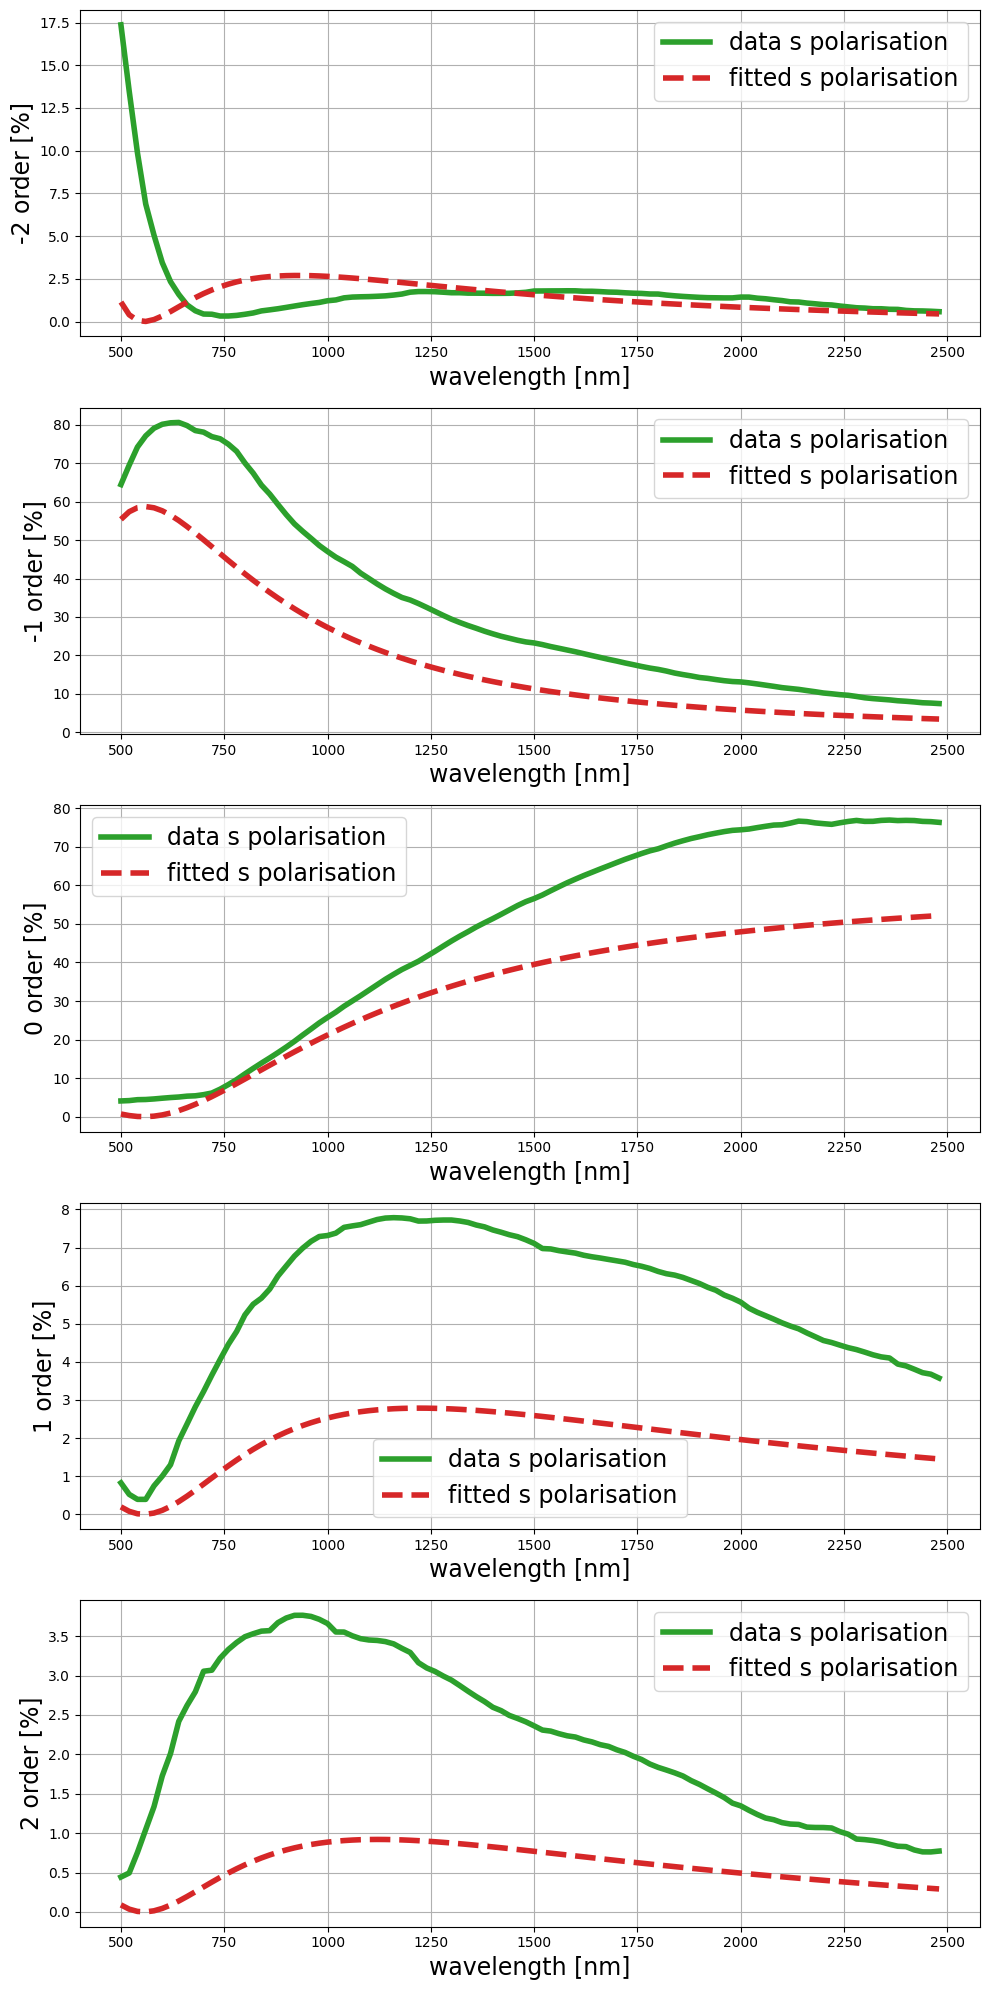

In [18]:
x_data = np.arange(500,2500,20)
# Example [height, power_a, power_b]
lower_bounds = [0]  
upper_bounds = [1200] 

analytic_linear_popt, pcov = curve_fit(objective_function, x_data, linear, bounds=(lower_bounds, upper_bounds))

print("Fitted parameters:", analytic_linear_popt)

y_fitted = np.squeeze(not_objective_function(x_data, *analytic_linear_popt))
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))
for fit, true ,ax, m in zip(y_fitted, linear_s, axes, range(-2,3)):
    ax.plot(x_data, true*100, label='data s polarisation', linewidth = 4, color = py_green)
    ax.plot(x_data, fit*100, '--', label='fitted s polarisation', linewidth = 4, color = py_red)
    #ax.set_title(title+' '+ str(incident_angle) +' incident angle in '+ mode, size=22)
    ax.set_xlabel('wavelength [nm]', size = 17)
    ax.set_ylabel(str(m) + ' order [%]', size = 17)
    ax.grid()
    ax.legend(fontsize = 17)
plt.tight_layout()
plt.savefig('analytical_linear.png')

## Atomic Force Microscopy scans

In [19]:
blaze = pd.read_csv('/kaggle/input/blaze-profile/blaze profile', delimiter= '  ', dtype = float)
blaze.columns = ['x', 'y']
curved_height = np.squeeze(blaze.y[146:242] - min(blaze.y[146:242]))
curved_height = curved_height[::-1]
curved_length = np.squeeze(blaze.x[146:242] - min(blaze.x[146:242]))


blaze = pd.read_csv('/kaggle/input/linear-blaze/blaze linear', delimiter= '  ', dtype = float, header= 3)
blaze.columns = ['x', 'y']
linear_height = blaze.y[60:158] - min(blaze.y[45:144])  #167
linear_length = blaze.x[60:158] - min(blaze.x[60:169])
linear_height = linear_height[::-1]

/tmp/ipykernel_19/2326563662.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  blaze = pd.read_csv('/kaggle/input/blaze-profile/blaze profile', delimiter= '  ', dtype = float)
/tmp/ipykernel_19/2326563662.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  blaze = pd.read_csv('/kaggle/input/linear-blaze/blaze linear', delimiter= '  ', dtype = float, header= 3)


## Confocal microscopy scans

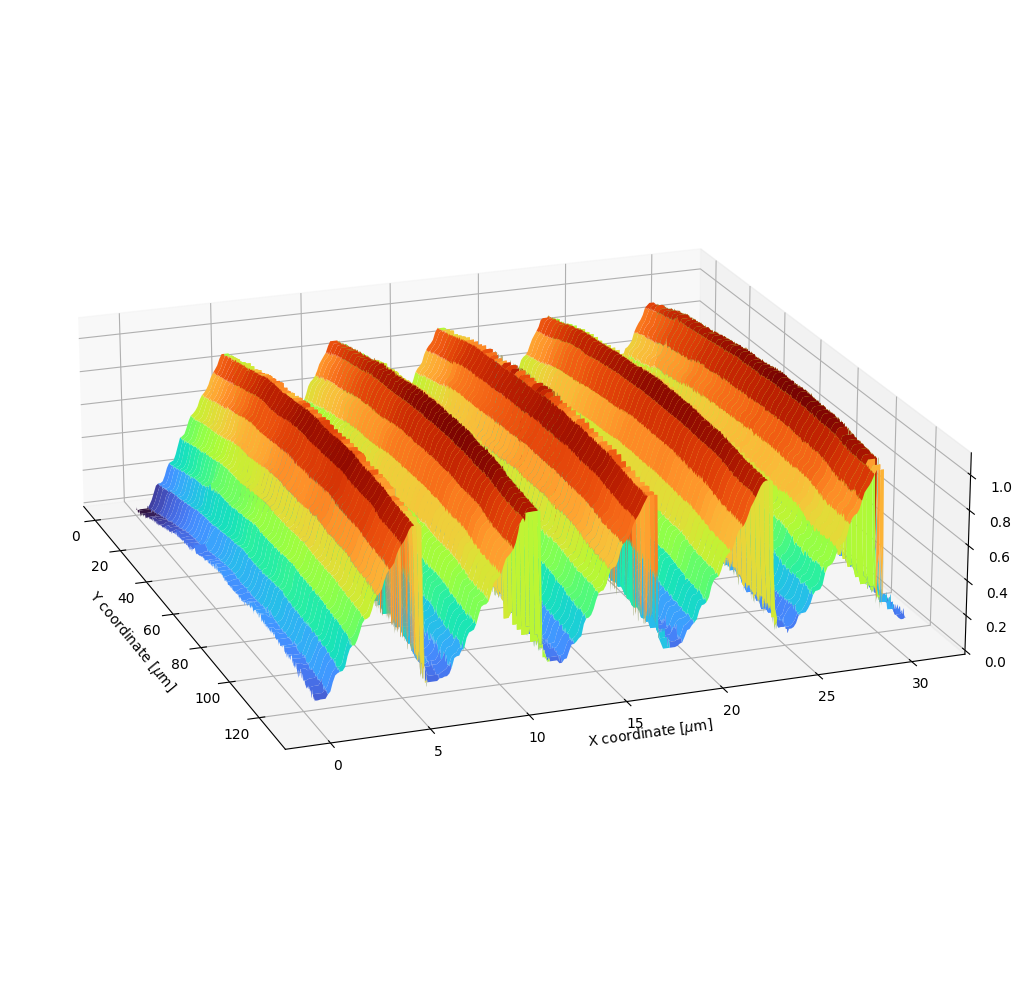

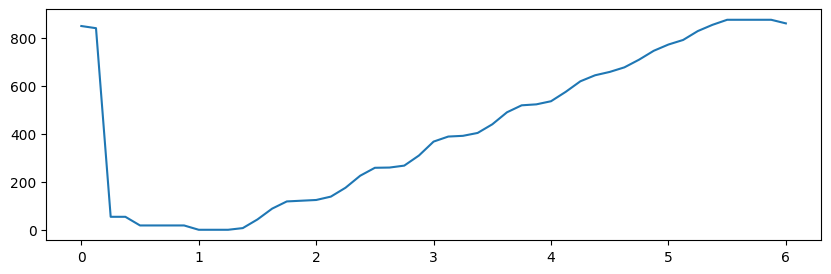

In [20]:
df = pd.read_csv('/kaggle/input/blazes-confocal/6um Perioda 100x objektiv_008_ProfileData.csv', header = 13, index_col = 0)
#df = df.clip(lower=2.0, upper=3.3)
#display(df)
df = median_filter(df.values, size=(6, 1), mode='reflect')
#df = df * 0.2

rows_to_take = df.shape[0] // 3
df = df[10:rows_to_take, :]
df = df - df.min()



# Create a figure and a 3D subplot

fig = plt.figure(figsize=(13,10))  # You can adjust these values as needed
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=-20)

# Create x and y indices
x_values = np.arange(df.shape[1]) * 0.125  # Multiply x values by 0.125
y_values = np.arange(df.shape[0]) * 0.125  # Multiply y values by 0.125
x, y = np.meshgrid(x_values, y_values)

# Plot the surface
ax.plot_surface(x, y, df, cmap='turbo')

# Labels and titl
#ax.set_zlim(0,1.25)
ax.set_xlabel('Y coordinate [$\mu$m]')
ax.set_ylabel('X coordinate [$\mu$m]')
#ax.set_zlabel('Height')
#ax.set_title('3D Surface Plot of Heights')

ax.set_box_aspect([1, 1, 0.3])  # e.g., stretching the z-axis by half
#ax.zaxis.set_label_coords(0.5, -0.15)  # You may need to adjust these values based on your plot

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)

plt.tight_layout()

# Show the plot
plt.savefig('confocal.png', dpi=300)  # Adjust dpi as necessary

plt.show()
#plt.figure(figsize = (10,2))


from scipy.signal import find_peaks
df = df[43:92, 56]
# Example data array
data = df - df.min()
plt.figure(figsize = (10,3))
plt.plot(np.arange(len(data))*0.125, data*1000, label = 'measured profile')
x_confocal = np.arange(len(data))*0.125
y_confocal = np.squeeze(data*1000)


## Comparison of grating profiles

#### Comparing grating profiles obtained from fitting the numerical model with those obtained via Atomic Force Microscopy and Confocal microscopy

The minimum of the curve is at coordinate: 0.9015
The minimum of the curve is at coordinate: 0.8931666666666667


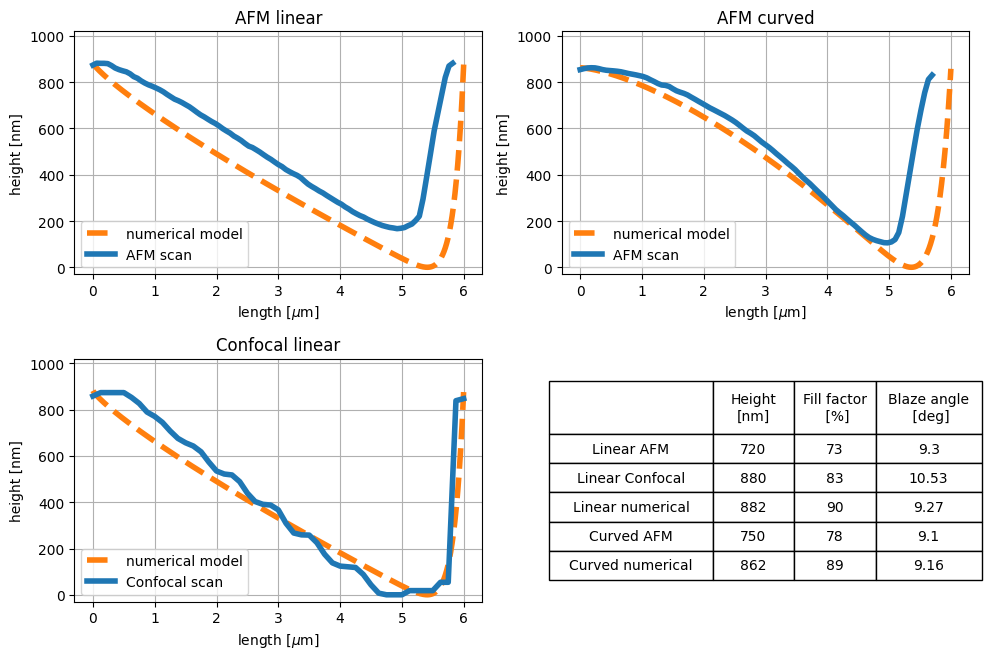

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6.7))  # 3 rows, 2 columns
x = np.arange(0,6000)*1e-3

axs[0, 0].plot(x, simulate_numerical_groove(np.arange(0,6000)*1e-9, *linear_popt), '--', linewidth = 4, label = 'numerical model', color = py_orange)
shift = max(simulate_numerical_groove(np.arange(0,6000)*1e-9, *linear_popt)) - max(linear_height*1e9)
axs[0, 0].plot(linear_length*1e6, linear_height*1e9 +shift, linewidth = 4, label = 'AFM scan', color = py_blue)
axs[0, 0].set_title('AFM linear')
axs[0, 0].grid()
axs[0, 0].legend()
axs[0, 0].set_ylim(-30, 1020)
axs[0, 0].set_ylabel('height [nm]')
axs[0, 0].set_xlabel('length [$\mu$m]')


axs[0, 1].plot(x, simulate_numerical_groove(np.arange(0,6000)*1e-9, *curved_popt), '--', linewidth = 4, label = 'numerical model', color = py_orange)
shift = max(simulate_numerical_groove(np.arange(0,6000)*1e-9, *curved_popt)) - max(curved_height*1e9)
axs[0, 1].plot(curved_length*1e6, curved_height*1e9 + shift, linewidth = 4, label = 'AFM scan', color = py_blue)
axs[0, 1].set_title('AFM curved')
axs[0, 1].grid()
axs[0, 1].legend()
axs[0, 1].set_ylim(-30, 1020)
axs[0, 1].set_ylabel('height [nm]')
axs[0, 1].set_xlabel('length [$\mu$m]')

min_index = np.argmin(simulate_numerical_groove(np.arange(0,6000)*1e-9, *linear_popt))
min_coordinate = (x[min_index])
print("The minimum of the curve is at coordinate:", min_coordinate/6)

min_index = np.argmin(simulate_numerical_groove(np.arange(0,6000)*1e-9, *curved_popt))
min_coordinate = (x[min_index])
print("The minimum of the curve is at coordinate:", min_coordinate/6)


axs[1, 0].plot(x, simulate_numerical_groove(np.arange(0,6000)*1e-9, *linear_popt), '--', label = 'numerical model', linewidth = 4, color = py_orange)
axs[1, 0].plot(x_confocal, y_confocal[::-1], label = 'Confocal scan', linewidth = 4, color = py_blue)
axs[1, 0].set_title('Confocal linear')
axs[1, 0].grid()
axs[1, 0].legend()
axs[1, 0].set_ylim(-30, 1020)
axs[1, 0].set_ylabel('height [nm]')
axs[1, 0].set_xlabel('length [$\mu$m]')

# Data for the table
table_data = [
    ["Linear AFM", 720, 73, 9.3],
    ["Linear Confocal", 880, 83, 10.53],
    ["Linear numerical", 882, 90, 9.27],
    ["Curved AFM", 750, 78, 9.1],
    ["Curved numerical", 862, 89, 9.16]
]
column_labels = ["", "Height\n[nm]", "Fill factor\n [%]", "Blaze angle\n [deg]"]

# Configure the eighth subplot for the table
axs[1, 1].axis('tight')
axs[1, 1].axis('off')  # Turn off the plot axes
table = axs[1, 1].table(cellText=table_data, colLabels=column_labels, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjust scale to fit the subplot
for (i, j), cell in table.get_celld().items():
    cell.set_height(0.12)
    cell.set_width(0.26)
    if i == 0:  # Only the first row contains the column labels
        cell.set_height(0.22)  # Increase the height of the header cells
    if j == 0:
        cell.set_width(0.4)
    if j == 1 or j == 2:
        cell.set_width(0.2)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.savefig('profiles_presentation.png', dpi=300)